# Fraud Detection in Credit Card Transactions

In [60]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from typing import List
import time
from scipy import stats
from scipy.stats import zscore
import random
import math
from math import log10
import statistics
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
import psutil

%matplotlib inline
start_time = pd.datetime.now()

## Data Preprocessing

### Import the Dataset

In [2]:
df_original = pd.read_excel('card transactions.xlsx', converters={'Merchnum': lambda x: str(x)})

In [3]:
# Convert contents of the Merch description dta field to uppercase
df_original['Merch description'] = df_original['Merch description'].str.upper()

In [4]:
df_original.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                   float64
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

Remove all records that do not have a value of "P" ("purchase") in the Transtype data field.

In [5]:
df_P = df_original.loc[df_original['Transtype'] == 'P']
print(len(df_P))
df_P.head()

96398


,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


## Data Imputation
In this section we fill missing values of the dataset.
#### CSV File of US Zip Codes
This portion of the code requires an additional downnload of a CSV file found at the reference URL below. This file is available for free.  
Reference:  https://simplemaps.com/data/us-zips

In [6]:
# Import the CSV file of US Zip Codes
# Reference:  https://simplemaps.com/data/us-zips
df_zipCodes = pd.read_csv('uszips.csv')

# Create a new column of the zip codes (zip2) and convert it to a float since our dataframe uses a float for the Zip data field
df_zipCodes['zip2'] = df_zipCodes.zip.astype('float64') 
df_zipCodes.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone,zip2
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico,601.0
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico,602.0
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico,603.0
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico,606.0
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico,610.0


In [7]:
# Make a dictionary to map the zip code to the state from the uszips.csv file
# zip2 is the dictionary key; state_id is the dictionary value
zip_dict = pd.Series(df_zipCodes.state_id.values,index=df_zipCodes.zip2.values).to_dict()

#### Merch state
The “Merch state” data field had 1,021 records with a missing value. Since this data field had the fewest number of records that required cleaning, we opted to start our data imputation with this data field. 

In [8]:
df_impute = deepcopy(df_P)
print(len(df_impute.loc[df_impute['Merch state'].isna()]))

# STEP 1: map the zip_dict contents to the "Merch state" data field
df_impute.loc[df_impute['Merch state'].isnull(),'Merch state'] = df_impute['Merch zip'].map(zip_dict) # reduced to 976
print(len(df_impute.loc[df_impute['Merch state'].isna()]))

1021
976


In [9]:
## STEP 2:
#### These lines of code enable us to use data fields with NaN values when using groupby ####
# Get rid of the records with NaN values in the Merch zip data field
zip_notnull = df_impute.loc[df_impute['Merch zip'].notnull(), ['Merch zip', 'Merch state']]

# Groupby zip, then find the mode of the state
zip_notnull_state = zip_notnull.groupby(['Merch zip'])['Merch state'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Make a dictionary to match the Recnum to the mode of the zip from the groupby done above
zip_notnull_state_dict = pd.Series(zip_notnull_state.values,index=zip_notnull_state.index+1).to_dict()

# Map the dictionary back to the "Merch state" data field 
df_impute.loc[df_impute['Merch state'].isnull(),'Merch state'] = df_impute['Recnum'].map(zip_notnull_state_dict) 
print(len(df_impute.loc[df_impute['Merch state'].isna()]))

959


In [10]:
# STEP 3: Groupby Merch description, then Cardnum, then find the mode of the state
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['state1'] = df_impute['Merch state'].fillna(df_impute.groupby(['Merch description','Cardnum'])['Merch state'].transform(f_zip)) 
len(df_impute.loc[df_impute['state1'].isna()])

904

In [11]:
# STEP 4: Groupby Cardnm, then date, then find the mode of the state
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan
df_impute['state2'] = df_impute['state1'].fillna(df_impute.groupby(['Cardnum','Date'])['state1'].transform(f_zip)) 
len(df_impute.loc[df_impute['state2'].isna()])

597

In [12]:
# STEP 5: Groupby Merch description, then find the mode of the state
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan
df_impute['state3'] = df_impute['state2'].fillna(df_impute.groupby(['Merch description'])['state2'].transform(f_zip)) 
len(df_impute.loc[df_impute['state3'].isna()])

129

In [13]:
# STEP 6: Groupby Cardnm, then date, then find the mode of the state
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan
df_impute['state4'] = df_impute['state3'].fillna(df_impute.groupby(['Cardnum','Date'])['state3'].apply(lambda x: x.ffill().bfill()))
len(df_impute.loc[df_impute['state4'].isna()])

126

In [14]:
# STEP 7: Groupby Cardnm, then find the mode of the state
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan
df_impute['state5'] = df_impute['state4'].fillna(df_impute.groupby(['Cardnum'])['state4'].apply(lambda x: x.ffill().bfill()))
len(df_impute.loc[df_impute['state5'].isna()])

31

In [15]:
# STEP 8: Fill remaining missing values with the Recnum to avoid linkages
df_impute['state6'] = df_impute['state5'].fillna(df_impute.Recnum)
len(df_impute.loc[df_impute['state6'].isna()])

0

#### Merch zip
The “Merch zip” data field had 4,301 records with a missing value. 

In [16]:
# Look at how many NaN values for "Merch zip"
len(df_impute.loc[df_impute['Merch zip'].isna()])

4301

In [17]:
# Look at how many NaN values for "Merchnum" 
len(df_impute.loc[df_impute['Merchnum'].isna()])

3199

In [18]:
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan
print(len(df_impute.loc[df_impute['Merch zip'].isna()]))

## STEP 1:
#### These lines of code enables us to use data fields with NaN values when using groupby ####
# Get rid of the records with NaN values in the Merchnum
merchnum_notnull = df_impute.loc[df_impute['Merchnum'].notnull(), ['Merchnum', 'state6','Merch zip']] 

# Groupby Merchnum, Merch state, then find the mode of the zip
merchnum_notnull_zip = merchnum_notnull.groupby(['Merchnum','state6'])['Merch zip'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Make a dictionary to match the Recnum to the mode of the zip from the groupby done above
merchnum_notnull_zip_dict = pd.Series(merchnum_notnull_zip.values,index=merchnum_notnull_zip.index+1).to_dict()

# Map the dictionary back to the "Merch zip" data field 
df_impute.loc[df_impute['Merch zip'].isnull(),'Merch zip'] = df_impute['Recnum'].map(merchnum_notnull_zip_dict) 
print(len(df_impute.loc[df_impute['Merch zip'].isna()]))

4301
2474


In [19]:
# STEP 2: Groupby Merch description, then the fully filled state (state6), then find the mode of the Merch zip
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip1'] = df_impute['Merch zip'].fillna(df_impute.groupby(['Merch description','state6'])['Merch zip'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip1'].isna()])

2151

In [20]:
# STEP 3: Groupby Merch description, then find the mode of the zip
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip2'] = df_impute['zip1'].fillna(df_impute.groupby(['Merch description'])['zip1'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip2'].isna()])

2030

In [21]:
# STEP 4: Groupby fully filled state (state6), then find the mode of the zip
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip3'] = df_impute['zip2'].fillna(df_impute.groupby(['state6'])['zip2'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip3'].isna()])

71

In [22]:
# STEP 5: Groupby Cardnm, then date, then find the mode of the zip
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip4'] = df_impute['zip3'].fillna(df_impute.groupby(['Cardnum','Date'])['zip3'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip4'].isna()])

54

In [23]:
# STEP 6: Groupby Merch description, then the fully filled state (state6), then find the mode of the zip
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip5'] = df_impute['zip4'].fillna(df_impute.groupby(['Merch description','state6'])['zip4'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip5'].isna()])

46

In [24]:
# STEP 7: Groupby Merch description, then find the mode of the zip (PRODUCED NO ADVANCEMENT IN RESULTS)
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip6'] = df_impute['zip5'].fillna(df_impute.groupby(['Merch description'])['zip5'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip6'].isna()])

46

In [25]:
# STEP 7: Groupby fully filled state (state6), then find the mode of the zip
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip7'] = df_impute['zip6'].fillna(df_impute.groupby(['state6'])['zip6'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip7'].isna()])

31

In [26]:
# STEP 8: Groupby Cardnm, then date, then find the mode of the zip (PRODUCED NO ADVANCEMENT IN RESULTS)
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip8'] = df_impute['zip7'].fillna(df_impute.groupby(['Cardnum','Date'])['zip7'].transform(f_mode)) 
len(df_impute.loc[df_impute['zip8'].isna()])

31

In [27]:
# STEP 8: Fill remaining missing values with the Recnum to avoid linkages
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

df_impute['zip9'] = df_impute['zip8'].fillna(df_impute.Recnum) 
len(df_impute.loc[df_impute['zip9'].isna()])

0

#### Merchnum
The “Merchnum” data field had 3,199 records with a missing value and 53 records with an erroneous value of “0” as its merchant number. 

In [28]:
f_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan

# View the number of records with "NaN" values for Merchnum
print(len(df_impute.loc[df_impute['Merchnum'].isna()]))

# STEP 1: Convert values of "0" in the Merchnum data field to "NaN" values
df_impute['Merchnum0'] = np.where(df_impute['Merchnum'] == '0', np.nan, df_impute['Merchnum'])
print(len(df_impute.loc[df_impute['Merchnum0'].isna()])) # Look at the new number of records with "NaN" values

# STEP 2: Groupby Merch description, then the fully filled zip (zip9), then find the mode of the Merchnum
df_impute['Merchnum1'] = df_impute['Merchnum0'].fillna(df_impute.groupby(['Merch description','zip9'])['Merchnum0'].transform(f_mode)) 
len(df_impute.loc[df_impute['Merchnum1'].isna()])

3199
3252


2169

In [29]:
# STEP 3: Groupby Merch description, then the fully filled state (state6), then find the mode of the Merchnum
df_impute['Merchnum2'] = df_impute['Merchnum1'].fillna(df_impute.groupby(['Merch description','state6'])['Merchnum1'].transform(f_mode)) 
len(df_impute.loc[df_impute['Merchnum2'].isna()])

2110

In [30]:
# STEP 4: Groupby Merch description, then find the mode of the Merchnum
df_impute['Merchnum3'] = df_impute['Merchnum2'].fillna(df_impute.groupby(['Merch description'])['Merchnum2'].transform(f_mode)) 
len(df_impute.loc[df_impute['Merchnum3'].isna()])

2095

In [31]:
# STEP 5: Fill remaining missing values with the Recnum to avoid linkages
df_impute['Merchnum4'] = df_impute['Merchnum3'].fillna(df_impute.Recnum) 
len(df_impute.loc[df_impute['Merchnum4'].isna()])

0

Save the fully imputed dataframe (raw form)

In [32]:
df_impute.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,state1,state2,state3,state4,state5,state6,zip1,zip2,zip3,zip4,zip5,zip6,zip7,zip8,zip9,Merchnum0,Merchnum1,Merchnum2,Merchnum3,Merchnum4
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,TN,TN,TN,TN,TN,TN,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,5509006296254,5509006296254,5509006296254,5509006296254,5509006296254
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,MA,MA,MA,MA,MA,MA,1803.0,1803.0,1803.0,1803.0,1803.0,1803.0,1803.0,1803.0,1803.0,61003026333,61003026333,61003026333,61003026333,61003026333
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,MD,MD,MD,MD,MD,MD,20706.0,20706.0,20706.0,20706.0,20706.0,20706.0,20706.0,20706.0,20706.0,4503082993600,4503082993600,4503082993600,4503082993600,4503082993600
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,TN,TN,TN,TN,TN,TN,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,5509006296254,5509006296254,5509006296254,5509006296254,5509006296254
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,TN,TN,TN,TN,TN,TN,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,38118.0,5509006296254,5509006296254,5509006296254,5509006296254,5509006296254


Save the fully imputed dataframe (clean form)

In [33]:
df_impute_final = df_P.copy()
df_impute_final.Merchnum = df_impute.Merchnum4
print(len(df_impute_final.loc[df_impute_final['Merchnum'].isna()]))
df_impute_final['Merch zip'] = df_impute['zip9'].astype(int)
print(len(df_impute_final.loc[df_impute_final['Merch zip'].isna()]))
df_impute_final['Merch state'] = df_impute['state6']
print(len(df_impute_final.loc[df_impute_final['Merch state'].isna()]))
df_impute_final['Merch description'] = df_impute_final['Merch description'].str.upper()

0
0
0


In [34]:
df_impute_final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0


In [35]:
df_impute_final.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                     int64
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

#### Remove the HIGH AMOUNT value 
This was a required exclusion outlined as a part of our project. We forgot to do it earlier, so we ended up doing it here.

In [36]:
df_impute_final.loc[df_impute_final['Recnum']==52715]

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
52714,52715,5142189135,2010-07-13,52715,INTERMEXICO,CA,92656,P,3102045.53,0


In [37]:
df_impute_final.drop(index=52714,inplace=True,axis=0)

In [38]:
df_impute_final.loc[df_impute_final['Recnum']==52715]

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud


In [39]:
df_impute_final.tail()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0
96752,96753,5142243247,2010-12-31,9108347680006,STAPLES NATIONAL #471,NJ,7606,P,554.64,0


## Feature Engineering
In this section we create new features based on the original ones in the dataset. 

### Create the Categorical Candidate Variables

In [40]:
start_convert = pd.datetime.now()
df_var = deepcopy(df_impute_final)

# Convert values to string type so that we can concatenate some of them together to make variables
cols_convert = [df_var.columns.drop(['Date','Fraud','Amount'])] # Don't convert these data fields
for item in cols_convert:
    df_var[item] = df_var[item].astype(str)

print('convert time', pd.datetime.now()-start_convert)
df_var.dtypes

convert time 0:00:00.281777


Recnum                       object
Cardnum                      object
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                    object
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

In [41]:
# Make variable combos from the Lesson 10 slides (slide 40)
df_var['card-merch'] = df_var['Cardnum'] + df_var['Merchnum'] # Class Q&A said not to use Merch description
df_var['card-zip'] = df_var['Cardnum'] + df_var['Merch zip']
df_var['card-state'] = df_var['Cardnum'] + df_var['Merch state']

Convert appropriate data fields to numbers

In [42]:
# Convert appropriate data fields back to integers for faster processing later in the code
start_convert=pd.datetime.now()

cols_int = ['Recnum','Cardnum','Merchnum','Merch zip']
cols_var = df_var.columns

for item in cols_var:
    temp = set(item.split('-'))
#     print(temp)
    if temp.issubset(cols_int):
        try:
            df_var[item] = df_var[item].astype(int)
        except:
            try:
                df_var[item] = df_var[item].astype('int64')
            except:
                print('The values are probably too big:', item)
                continue

print('convert time', pd.datetime.now()-start_convert)
df_var.dtypes

The values are probably too big: Merchnum
convert time 0:00:00.035558


Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                     int64
Transtype                    object
Amount                      float64
Fraud                         int64
card-merch                   object
card-zip                     object
card-state                   object
dtype: object

### Days-Since Variables  
It is number of days since the last time a categorical data field or candidate variable was seen for a particular transaction record.

In [43]:
def ds(dataframe, g1, g2, name):
#     'Helps with calculating the day since variables'
    day_since = dataframe.groupby(g1)[g1].first()
    day_since = day_since.rename_axis(['None' for i in range(len(g1))]).groupby(g2).diff()
    day_since.columns = [name]
    day_since = day_since.rename_axis(g1)
    day_since[name] = day_since[name].dt.days.fillna(0)
    day_since = day_since.reset_index()
    return day_since

In [44]:
# Example from Prof's code
# ssn - finds the numbers of "days since" for the "ssn" 
start_daySince = pd.datetime.now()
day_card = ds(df_var, ['Cardnum', 'Date'], 'Cardnum', 'card_daysSince')
print("done!", pd.datetime.now()-start_daySince)
day_card

done! 0:00:01.315008


,Cardnum,Date,card_daysSince
0,5142110002,2010-10-12,0.0
1,5142110081,2010-03-08,0.0
2,5142110081,2010-11-26,263.0
3,5142110081,2010-12-27,31.0
4,5142110313,2010-10-07,0.0
...,...,...,...
61900,5142847398,2010-03-21,3.0
61901,5142847398,2010-03-22,1.0
61902,5142847398,2010-03-24,2.0
61903,5142847398,2010-03-28,4.0


In [45]:
time_ds_all=pd.datetime.now()
# Calculate the Days Since variables for the required columns
ds_cols = ['Cardnum','Merchnum','card-merch','card-state','card-zip']

ds_dict={}
for col in ds_cols:
    curr_time=pd.datetime.now()
    curr_name = 'daysSince_' + col
    
    # Calculate the days-since variable (ds) and assign it to a global variable (curr_name)
    vars()[curr_name] = ds(df_var, [col, 'Date'], col, col+'_daysSince')
    ds_dict[curr_name] = vars()[curr_name] # Save results to a dictionary
    
    print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
    
print("DONE!", pd.datetime.now()-time_ds_all)

Done with: Cardnum ; Time: 0:00:01.265444
Done with: Merchnum ; Time: 0:00:10.781707
Done with: card-merch ; Time: 0:00:28.874647
Done with: card-state ; Time: 0:00:11.128392
Done with: card-zip ; Time: 0:00:23.553132
DONE! 0:01:15.604240


In [46]:
ds_dict.keys()

dict_keys(['daysSince_Cardnum', 'daysSince_Merchnum', 'daysSince_card-merch', 'daysSince_card-state', 'daysSince_card-zip'])

In [47]:
df_ds = df_var.copy()

# Merge the days-since variables with the main dataset
for item in ds_dict.keys():
    col_variable = item.split('_')[1]
    df_ds = pd.merge(df_ds, vars()[item], how='left', left_on=[col_variable,'Date'], right_on=[col_variable,'Date'])

In [48]:
df_ds

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,0.0,0.0,0.0,0.0,0.0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,0.0,0.0,0.0,0.0,0.0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,0.0,0.0,0.0,0.0,0.0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,0.0,0.0,0.0,0.0,0.0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,51422760533500000006160,514227605341042,5142276053KY,37.0,0.0,0.0,37.0,37.0
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,51422257018090710030950,514222570145248,5142225701OH,2.0,9.0,11.0,2.0,11.0
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,51422264864503057341100,514222648645150,5142226486OH,1.0,4.0,0.0,1.0,0.0
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,51422446198834000695412,514224461992656,5142244619CA,9.0,1.0,26.0,26.0,26.0


In [ ]:
# Save the days-since variables
# df_ds.to_csv('df_daysSince.csv')

### Frequency Variables  
They indicate the speed at which categorical data fields and candidate variables were seen in a dataset for a particular transaction record.

#### Create Columns for the Necessary Time Periods
This makes new columns for the various time periods.

In [49]:
# Make a list of variable combinations to iterate through and create time-related variables
cols_drop = ['Recnum','Date','Merch description','Merch state','Merch zip','Transtype','Amount','Fraud']
var_combos = df_var.drop(cols_drop,axis=1).columns

# Create column names
time_list = [0,1,3,7,14,30]
time_joined =[]
for time in time_list:
    time_joined.append('join_ts_'+str(time))
    
start_copy = pd.datetime.now()
df_var1 = deepcopy(df_var)
df_var2 = deepcopy(df_var)
print('copy time', pd.datetime.now()-start_copy)

# Creating columns for time
start_loop=pd.datetime.now()
for time in time_list:
    temp_endTime = 'join_ts_' + str(time)
    df_var2[temp_endTime] = df_var2['Date'] + dt.timedelta(time)
print('first loop', pd.datetime.now()-start_loop)

copy time 0:00:00.013889
first loop 0:00:00.016109


#### Create the Frequency Candidate Variables
This makes the frequency variables. It's counting the number of records it sees based on the time period. For instance, it counts all the records for a Cardnum it sees over the last 3 days based on the date and Recnum. It only counts the current record and those records in the past for those last 3 days.

In [50]:
start_loop2=pd.datetime.now()
df_final = deepcopy(df_var.set_index('Recnum'))

for item in var_combos:
    df_var3 = df_var1[['Recnum','Date',item]]
    temp_list = time_joined + [item]
    df_var4 = df_var2[temp_list + ['Recnum']].copy()
    df_var4.rename(columns={'Recnum':'Recnum2'},inplace=True) # this causes a warning to arise
    
    df_temp = pd.merge(df_var3, df_var4, left_on=[item], right_on=[item])

    for time in time_list:
        temp_endTime = 'join_ts_' + str(time)
        df2_temp = df_temp[(df_temp['Date'] <= df_temp[temp_endTime]) & (df_temp['Recnum2'] <= df_temp['Recnum'])]
        
        temp_groupby = df2_temp[['Recnum','Date']].groupby('Recnum')
        
        temp_name = item + '_' + 'freq' + str(time) + '_'
        df_final = pd.merge(df_final, getattr(temp_groupby,'count')().add_prefix(temp_name), left_index=True, right_index=True, how='left')

print('second loop', pd.datetime.now()-start_loop2)
print(len(df_final.columns))
df_final.head()

second loop 0:00:23.094071
42


,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date
Recnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,2,2,2,2,2,2,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [ ]:
# Save the frequency variables
# df_final.to_csv('df_frequency_vars.csv')

### Velocity Change Variables
They indicate the number of appearences with that group seen in the recent past / number of appearences with that same group seen in the past 1, 3, 7, 14, 30, etc. days / number days

In [51]:
start_loop3=pd.datetime.now()
groupbyvar_denom = deepcopy(var_combos)
days_numer = ['0','1']
days_denom = ['7','14','30']

for b in groupbyvar_denom:
    for c in days_numer:
        for d in days_denom:
            temp = d
            df_final[b + '_' + c + '_dayfreq' + '_div_' + d + '_dayfreq' + '_velchange'] = \
                df_final[b + '_freq' + c + '_Date'] / \
                df_final[b + '_freq' + d + '_Date'] / float(temp)
print('third loop', pd.datetime.now() - start_loop3)

third loop 0:00:00.059850


In [52]:
print(len(df_final.columns))
df_final.head()

72


,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange
Recnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
5,51421

In [ ]:
# Save the frequency and velocity change variables
# df_final.to_csv('df_freq_velchange_vars.csv')

### Merge dataframes for all variables

In [53]:
# Reset the index so that the Recnum returns to being a normal column
df_final.reset_index(inplace=True)
df_final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118

In [54]:
# Merge df_final (frequency and velocity change) and df_ds (days-since)
df_all_vars = pd.merge(df_final, df_ds, on=list(df_var.columns))
df_all_vars

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.0

In [ ]:
# Save the merged dataframe (this is missing the amount variables)
# df_all_vars.to_csv('df_noamount_vars.csv')

In [55]:
# Optimize Function
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

### Amount Velocity Variables
The  number of records (transactions) in a given time period

In [56]:
# Make variable combos from the Lesson 10 slides (slide 40)
main_dataset_filled = deepcopy(df_impute_final)
main_dataset_filled['Cardnum_|_merchnum'] = main_dataset_filled['Cardnum'].astype('str') + main_dataset_filled['Merchnum'].astype('str') # Class Q&A said not to use Merch description
main_dataset_filled['Cardnum_|_zip'] = main_dataset_filled['Cardnum'].astype('str') + main_dataset_filled['Merch zip'].astype('str')
main_dataset_filled['Cardnum_|_state'] = main_dataset_filled['Cardnum'].astype('str') + main_dataset_filled['Merch state'].astype('str')

In [57]:
var_combos = ['Cardnum','Merchnum','Cardnum_|_zip','Cardnum_|_state','Cardnum_|_merchnum']

In [61]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 18.0


In [64]:
time_joined =['join_ts1']
for num in time_list:
    time_joined.append('join_ts2_'+str(num))

In [71]:
# Making time variables
start=pd.datetime.now()

time_list = [0,1,3,7,14,30]
main_dataset_filled['join_ts1']=main_dataset_filled['Date']
# dt_i
for dt_i in time_list:
    time = 'join_ts2_'+str(dt_i)
    main_dataset_filled[time]=main_dataset_filled['Date'] + dt.timedelta(dt_i)
print('Completed ',pd.datetime.now()-start)

Completed  0:00:00.015444


In [73]:
df_var1 = main_dataset_filled.copy()
df_var2 = main_dataset_filled.copy()

In [ ]:
# 'Cardnum_|_zip_totalamount14_Amount2' = total amount for the past 14 days 
# for the same cardnumber and zip

### Total Amount Variables  
The total amount of the number of records (transactions) in a given time period

In [74]:
start_loop2=pd.datetime.now()
df_final = deepcopy(main_dataset_filled.set_index('Recnum'))

for item in var_combos:
    df_var3 = df_var1[['Recnum','Date','Amount',item]]
    temp_list = time_joined + [item]
    df_var4 = df_var2[temp_list + ['Recnum','Amount']].copy()
    df_var4.rename(columns={'Recnum':'Recnum2','Amount':'Amount2'},inplace=True) # this causes a warning to arise
#     df_var4['record2'] = df_var2['record'] # this causes a warning to arise
    
    df_temp = pd.merge(df_var3, df_var4, left_on=[item], right_on=[item])

    for time in time_list:
        temp_endTime = 'join_ts2_' + str(time)
#         df2_temp = df_temp[(df_temp['date'] >= df_temp['join_ts1']) & (df_temp['date'] <= df_temp[temp_endTime])] # Original from TA
        df2_temp = df_temp[(df_temp['Date'] <= df_temp[temp_endTime]) & (df_temp['Recnum2'] <= df_temp['Recnum'])]
        
        temp_groupby = df2_temp[['Recnum','Amount2']].groupby('Recnum')
        
        temp_name = item + '_' + 'totalamount' + str(time) + '_'
        df_final = pd.merge(df_final, getattr(temp_groupby,'sum')().add_prefix(temp_name), left_index=True, right_index=True, how='left')
#         break
#     break
print('second loop', pd.datetime.now()-start_loop2)
print(len(df_final.columns))
df_final.head()

second loop 0:00:28.784288
49


,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_|_merchnum,Cardnum_|_zip,Cardnum_|_state,join_ts1,join_ts2_0,join_ts2_1,join_ts2_3,join_ts2_7,join_ts2_14,join_ts2_30,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2
Recnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,3.62,3.62,3.62,3.62,3.62,3.62,7.24,7.24,7.24,7.24,7.24,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,7.24,7.24,7.24,7.24,7.24,7.24,10.86,10.86,10.86,10.86,10.86,10.86,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24


In [75]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 16.9


### Median Amount variables  
The median amount of the number of records (transactions) in a given time period

In [76]:
start_loop2=pd.datetime.now()
# df_final = deepcopy(main_dataset_filled.set_index('Recnum'))

for item in var_combos:
    df_var3 = df_var1[['Recnum','Date','Amount',item]]
    temp_list = time_joined + [item]
    df_var4 = df_var2[temp_list + ['Recnum','Amount']].copy()
    df_var4.rename(columns={'Recnum':'Recnum2','Amount':'Amount2'},inplace=True) # this causes a warning to arise
#     df_var4['record2'] = df_var2['record'] # this causes a warning to arise
    
    df_temp = pd.merge(df_var3, df_var4, left_on=[item], right_on=[item])

    for time in time_list:
        temp_endTime = 'join_ts2_' + str(time)
#         df2_temp = df_temp[(df_temp['date'] >= df_temp['join_ts1']) & (df_temp['date'] <= df_temp[temp_endTime])] # Original from TA
        df2_temp = df_temp[(df_temp['Date'] <= df_temp[temp_endTime]) & (df_temp['Recnum2'] <= df_temp['Recnum'])]
        
        temp_groupby = df2_temp[['Recnum','Amount2']].groupby('Recnum')
        
        temp_name = item + '_' + 'median' + str(time) + '_'
        df_final = pd.merge(df_final, getattr(temp_groupby,'median')().add_prefix(temp_name), left_index=True, right_index=True, how='left')
#         break
#     break
print('second loop', pd.datetime.now()-start_loop2)
print(len(df_final.columns))
df_final.head()

second loop 0:00:28.613825
79


,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_|_merchnum,Cardnum_|_zip,Cardnum_|_state,join_ts1,join_ts2_0,join_ts2_1,join_ts2_3,join_ts2_7,join_ts2_14,join_ts2_30,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2
Recnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,5

In [77]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 17.0


In [ ]:
# df_final = optimize(df_final,['Date'])

### Mean Amount Variables  
The average amount of the number of records (transactions) in a given time period

In [78]:
start_loop2=pd.datetime.now()
# df_final = deepcopy(main_dataset_filled.set_index('Recnum'))

for item in var_combos:
    df_var3 = df_var1[['Recnum','Date','Amount',item]]
    temp_list = time_joined + [item]
    df_var4 = df_var2[temp_list + ['Recnum','Amount']].copy()
    df_var4.rename(columns={'Recnum':'Recnum2','Amount':'Amount2'},inplace=True) # this causes a warning to arise
#     df_var4['record2'] = df_var2['record'] # this causes a warning to arise
    
    df_temp = pd.merge(df_var3, df_var4, left_on=[item], right_on=[item])

    for time in time_list:
        temp_endTime = 'join_ts2_' + str(time)
#         df2_temp = df_temp[(df_temp['date'] >= df_temp['join_ts1']) & (df_temp['date'] <= df_temp[temp_endTime])] # Original from TA
        df2_temp = df_temp[(df_temp['Date'] <= df_temp[temp_endTime]) & (df_temp['Recnum2'] <= df_temp['Recnum'])]
        
        temp_groupby = df2_temp[['Recnum','Amount2']].groupby('Recnum')
        
        temp_name = item + '_' + 'mean' + str(time) + '_'
        df_final = pd.merge(df_final, getattr(temp_groupby,'mean')().add_prefix(temp_name), left_index=True, right_index=True, how='left')
#         break
#     break
print('second loop', pd.datetime.now()-start_loop2)
print(len(df_final.columns))
df_final.head()

second loop 0:00:28.191120
109


,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_|_merchnum,Cardnum_|_zip,Cardnum_|_state,join_ts1,join_ts2_0,join_ts2_1,join_ts2_3,join_ts2_7,join_ts2_14,join_ts2_30,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2,Cardnum_mean0_Amount2,Cardnum_mean1_Amount2,Cardnum_mean3_Amount2,Cardnum_mean7_Amount2,Cardnum_mean14_Amount2,Cardnum_mean30_Amount2,Merchnum_mean0_Amount2,Merchnum_mean1_Amount2,Merchnum_mean3_Amount2,Merchnum_mean7_Amount2,Merchnum_mean14_Amount2,Merchnum_mean30_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_zip_mean30_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean30_Amount2
Recnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,2010-01-01,2010-01-01,2010-01-02,2010-01-04,2010-01-08,2010-01-15,2010-01-31,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,

In [79]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 17.1


### MAX Amount Variables  
The maximum amount of the number of records (transactions) in a given time period

In [80]:
start_loop2=pd.datetime.now()
# df_final = deepcopy(main_dataset_filled.set_index('Recnum'))

for item in var_combos:
    df_var3 = df_var1[['Recnum','Date','Amount',item]]
    temp_list = time_joined + [item]
    df_var4 = df_var2[temp_list + ['Recnum','Amount']].copy()
    df_var4.rename(columns={'Recnum':'Recnum2','Amount':'Amount2'},inplace=True) # this causes a warning to arise
#     df_var4['record2'] = df_var2['record'] # this causes a warning to arise
    
    df_temp = pd.merge(df_var3, df_var4, left_on=[item], right_on=[item])

    for time in time_list:
        temp_endTime = 'join_ts2_' + str(time)
#         df2_temp = df_temp[(df_temp['date'] >= df_temp['join_ts1']) & (df_temp['date'] <= df_temp[temp_endTime])] # Original from TA
        df2_temp = df_temp[(df_temp['Date'] <= df_temp[temp_endTime]) & (df_temp['Recnum2'] <= df_temp['Recnum'])]
        
        temp_groupby = df2_temp[['Recnum','Amount2']].groupby('Recnum')
        
        temp_name = item + '_' + 'max' + str(time) + '_'
        df_final = pd.merge(df_final, getattr(temp_groupby,'max')().add_prefix(temp_name), left_index=True, right_index=True, how='left')
#         break
#     break
print('second loop', pd.datetime.now()-start_loop2)
print(len(df_final.columns))
df_final.head()

second loop 0:00:27.696463
139


,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_|_merchnum,Cardnum_|_zip,Cardnum_|_state,join_ts1,join_ts2_0,join_ts2_1,join_ts2_3,join_ts2_7,join_ts2_14,join_ts2_30,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2,Cardnum_mean0_Amount2,Cardnum_mean1_Amount2,Cardnum_mean3_Amount2,Cardnum_mean7_Amount2,Cardnum_mean14_Amount2,Cardnum_mean30_Amount2,Merchnum_mean0_Amount2,Merchnum_mean1_Amount2,Merchnum_mean3_Amount2,Merchnum_mean7_Amount2,Merchnum_mean14_Amount2,Merchnum_mean30_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_zip_mean30_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_max0_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max7_Amount2,Cardnum_max14_Amount2,Cardnum_max30_Amount2,Merchnum_max0_Amount2,Merchnum_max1_Amount2,Merchnum_max3_Amount2,Merchnum_max7_Amount2,Merchnum_max14_Amount2,Merchnum_max30_Amount2,Cardnum_|_zip_max0_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_state_max1_Amount2,Cardnum_|_state_max3_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_merchnum_max0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_merchnum_max30_Amount2
Recnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439550900629

In [81]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 17.2


In [82]:
df_final = optimize(df_final,['Date'])

In [83]:
df_final.head()

,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_|_merchnum,Cardnum_|_zip,Cardnum_|_state,join_ts1,join_ts2_0,join_ts2_1,join_ts2_3,join_ts2_7,join_ts2_14,join_ts2_30,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2,Cardnum_mean0_Amount2,Cardnum_mean1_Amount2,Cardnum_mean3_Amount2,Cardnum_mean7_Amount2,Cardnum_mean14_Amount2,Cardnum_mean30_Amount2,Merchnum_mean0_Amount2,Merchnum_mean1_Amount2,Merchnum_mean3_Amount2,Merchnum_mean7_Amount2,Merchnum_mean14_Amount2,Merchnum_mean30_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_zip_mean30_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_max0_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max7_Amount2,Cardnum_max14_Amount2,Cardnum_max30_Amount2,Merchnum_max0_Amount2,Merchnum_max1_Amount2,Merchnum_max3_Amount2,Merchnum_max7_Amount2,Merchnum_max14_Amount2,Merchnum_max30_Amount2,Cardnum_|_zip_max0_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_state_max1_Amount2,Cardnum_|_state_max3_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_merchnum_max0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_merchnum_max30_Amount2
Recnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.620000,0,514219043955090

In [87]:
start_column = df_final.columns.get_loc('Cardnum_totalamount0_Amount2')
for col_names in df_final.columns[start_column:]:
#     print(col_names)
#  the number of days in each column is the column index mod length of time array
    number_index = time_list[(df_final.columns.get_loc(col_names)%len(time_list))-1]
#     we split the name of the array to keep the first part and use it to create the new column names
    new_col_name = col_names.split(str(number_index))[0]+'_'+str(number_index)+'_actual'
#     print(new_col_name)
    df_final[new_col_name] = df_final["Amount"]/df_final[col_names]


#### verification of amount variables

In [89]:
# df_final['Merchnum'][8]
df_final[['Merchnum','Date','Amount','Merchnum_max7_Amount2','Merchnum_max_7_actual']].loc[df_final['Merchnum']=='6098208200062']
# np.array([df_final.columns == 'Merchnum_max_7_actual']).sum()
# df_final['Merch']

,Merchnum,Date,Amount,Merchnum_max7_Amount2,Merchnum_max_7_actual
Recnum,,,,,
8,6098208200062,2010-01-01,230.320007,230.320007,1.000000
521,6098208200062,2010-01-05,267.220001,267.220001,1.000000
5052,6098208200062,2010-01-24,140.149994,140.149994,1.000000
25240,6098208200062,2010-04-06,685.619995,685.619995,1.000000
28338,6098208200062,2010-04-18,735.369995,735.369995,1.000000
33190,6098208200062,2010-05-04,10.850000,10.850000,1.000000
33926,6098208200062,2010-05-08,9.300000,10.850000,0.857143
54055,6098208200062,2010-07-18,4749.169922,4749.169922,1.000000
56826,6098208200062,2010-07-26,554.940002,554.940002,1.000000


#### Explanation of column name:
Cardnum_|_state_max_30_Amount2 = max amount at this card number in this state over the past 30 days
Cardnum_|_state_max_30_actual = actual amount/ max at this card number in this state over the past 30 days

In [81]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 17.2


### Amount Velocity Change Variables


In [90]:
# iterates through  the variables created with the var_combos columns and finds the relative 
# velocity variables. Divides the number of days of days_numer array with the days_denom one
start_loop3=pd.datetime.now()
groupbyvar_denom = deepcopy(var_combos)
days_numer = ['0','1']
days_denom = ['7','14','30']
# Cardnum_totalamount0_Amount2_/_Cardnum_totalamount3_Amount2
for b in groupbyvar_denom:
    for c in days_numer:
        for d in days_denom:
            temp = d
            df_final[b + '_' + c + '_dayamount' + '_div_' + d + '_dayamount' + '_velchange'] = \
                df_final[b+'_totalamount'+c+'_Amount2'] / \
                df_final[b+'_totalamount'+d+'_Amount2'] / float(temp)
print('third loop', pd.datetime.now() - start_loop3)

third loop 0:00:00.041360


## Create Benford's Law variables 

In [ ]:
# remove FEDEX first only for this part

In [91]:
# main_dataset_filled.head()
applic_ds_df = main_dataset_filled[['Recnum','Cardnum','Date','Merchnum','Merch description','Amount','Fraud']]
# add column with all ones
applic_ds_df["Cardnum_U*"] = np.ones(applic_ds_df.shape[0])
applic_ds_df["Merchnum_U*"] = np.ones(applic_ds_df.shape[0])
applic_ds_df

/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Recnum,Cardnum,Date,Merchnum,Merch description,Amount,Fraud,Cardnum_U*,Merchnum_U*
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,3.62,0,1.0,1.0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,31.42,0,1.0,1.0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,178.49,0,1.0,1.0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,3.62,0,1.0,1.0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,3.62,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,84.79,0,1.0,1.0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,118.75,0,1.0,1.0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",363.56,0,1.0,1.0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,2202.03,0,1.0,1.0


In [92]:
# remove FEDEX first only for this part
# drop fedex values
fed_ex_index = applic_ds_df['Merch description'].str.contains('FEDEX SHP')
print(fed_ex_index.sum())

applic_ds_df = applic_ds_df.drop(applic_ds_df.index[fed_ex_index])
applic_ds_df.shape

11767


(84630, 9)

In [93]:
def get_N_high_arr(df):
    x = np.abs(df)
    e = np.floor(np.log10(x))
    msg_tst_arr = np.floor(x*10**-e).astype('int')
    hig_dig = np.sum(msg_tst_arr > 2)
    return np.maximum(hig_dig,1)

In [94]:
def get_Nlow_arr(df):
    x = np.abs(df)
    e = np.floor(np.log10(x))
    msg_tst_arr = np.floor(x*10**-e).astype('int')
    low_dig =   np.sum(msg_tst_arr <= 2)
    return np.maximum(low_dig,1)

In [95]:
def find_Benford_vars(df_name, col_name):
# this function creates benford's law variable for each different col_name entry, taking in 
# consideration all the entries BEFORE time_index. Time index is ONLY the record number
# returns each variable in an new dataframe
# requires get_Nlow_arr & get_N_high_arr functions
#  example card_benford_vars_df = find_Benford_vars(card_df,'Cardnum')

    uniq_cards = df_name[col_name].unique()
    new_df = pd.DataFrame({col_name:[],'n_low':[],'n_high':[]})

    # find n high and n low for each entry
    start_time = pd.datetime.now()
    for card_no in uniq_cards: 
        n_low_count = get_Nlow_arr(df_name[df_name[col_name] == card_no]['Amount'].values)
        n_high_count = get_N_high_arr(df_name[df_name[col_name] == card_no]['Amount'].values)
        new_df = new_df.append(pd.DataFrame.from_records([{col_name:card_no,'n_low':n_low_count,'n_high':n_high_count}]), ignore_index=True)
    print('duration: ', pd.datetime.now() - start_time)

    # set any values with n_high or n_low = 0 to 1
#     new_df['n_low'] = np.where(new_df['n_low'] == 0,1,new_df['n_low'])
#     new_df['n_high'] = np.where(new_df['n_high'] == 0,1,new_df['n_high'])

    # find R and 1/R 
    new_df['R'] = (new_df['n_low']*1.096)/new_df['n_high']
    new_df['1/R'] = 1/new_df['R']
    
    # find U = max(R,1/R)
    new_df['U'] = np.maximum(new_df['R'],new_df['1/R'])
    # find column n
    new_df['n'] = new_df['n_high'] + new_df['n_low']
    
#     smoothing formula
    n_mid = 15
    c = 3
    new_df['t'] = (new_df['n']-n_mid)/c
    new_df[col_name+'_U*'] = 1 + (new_df['U']-1)/(1+np.exp(-new_df['t']))
    new_df[['Recnum','Cardnum','n_low','n_high']] = new_df[['Recnum','Cardnum','n_low','n_high']].astype('int')
    return new_df

In [96]:
main_dataset_filled.head()
applic_ds_df = main_dataset_filled[['Recnum','Cardnum','Date','Merchnum','Merch description','Amount','Fraud']]
# add column with all ones
applic_ds_df["Cardnum_U*"] = np.ones(applic_ds_df.shape[0])
applic_ds_df["Merchnum_U*"] = np.ones(applic_ds_df.shape[0])
applic_ds_df

/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Recnum,Cardnum,Date,Merchnum,Merch description,Amount,Fraud,Cardnum_U*,Merchnum_U*
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,3.62,0,1.0,1.0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,31.42,0,1.0,1.0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,178.49,0,1.0,1.0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,3.62,0,1.0,1.0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,3.62,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,84.79,0,1.0,1.0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,118.75,0,1.0,1.0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",363.56,0,1.0,1.0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,2202.03,0,1.0,1.0


In [97]:
# drop fedex values
fed_ex_index = applic_ds_df['Merch description'].str.contains('FEDEX SHP')
print(fed_ex_index.sum())

applic_ds_df = applic_ds_df.drop(applic_ds_df.index[fed_ex_index])
applic_ds_df.shape

11767


(84630, 9)

In [98]:
applic_ds_df

,Recnum,Cardnum,Date,Merchnum,Merch description,Amount,Fraud,Cardnum_U*,Merchnum_U*
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,31.42,0,1.0,1.0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,178.49,0,1.0,1.0
7,8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,230.32,0,1.0,1.0
8,9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,62.11,0,1.0,1.0
13,14,5142124791,2010-01-01,5725000466504,CDW*GOVERNMENT INC,106.89,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,84.79,0,1.0,1.0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,118.75,0,1.0,1.0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",363.56,0,1.0,1.0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,2202.03,0,1.0,1.0


### a) for Cardnum

In [99]:
start_loop2=pd.datetime.now()

for current_record_no in applic_ds_df['Recnum'].values:
#     print(current_record_no)
    current_df = applic_ds_df[applic_ds_df['Recnum'] <= current_record_no]
    # all credit card numbers untill that record number
#     current_df['Cardnum'].values
    # credit card number of current record number
    current_card_no = current_df['Cardnum'].values[-1]
#     smoothing formula
    n_mid = 15
    c = 3
    n_low_count = get_Nlow_arr(current_df[current_df['Cardnum'] == current_card_no]['Amount'].values)
    n_high_count = get_N_high_arr(current_df[current_df['Cardnum'] == current_card_no]['Amount'].values)
#     print(n_low_count)
#     print(n_high_count)
    R = n_low_count*1.096/n_high_count
#     print('R:',R)
    U = np.maximum(R,(1/R))
#     print('U:',U)
    t = ((n_high_count+n_low_count)-n_mid)/c
    U_star = 1+(U-1)/(1+np.exp(-t))
#     print('U*:',U_star)
    set_index_row = current_df[current_df['Recnum'] == current_record_no].index[0]
    set_index_col = applic_ds_df.columns.get_loc('Cardnum_U*')
    applic_ds_df.loc[set_index_row,'Cardnum_U*'] = U_star
print('Cardnumber U*:', pd.datetime.now()-start_loop2)

Cardnumber U*: 0:09:09.313227


### b) for Merchnum

In [100]:
start_loop2=pd.datetime.now()

for current_record_no in applic_ds_df['Recnum'].values:
#     print(current_record_no)
    current_df = applic_ds_df[applic_ds_df['Recnum'] <= current_record_no]
    current_card_no = current_df['Merchnum'].values[-1]
#     smoothing formula
    n_mid = 15
    c = 3
    n_low_count = get_Nlow_arr(current_df[current_df['Merchnum'] == current_card_no]['Amount'].values)
    n_high_count = get_N_high_arr(current_df[current_df['Merchnum'] == current_card_no]['Amount'].values)
#     print(n_low_count)
#     print(n_high_count)
    R = n_low_count*1.096/n_high_count
#     print('R:',R)
    U = np.maximum(R,(1/R))
#     print('U:',U)
    t = ((n_high_count+n_low_count)-n_mid)/c
    U_star = 1+(U-1)/(1+np.exp(-t))
#     print('U*:',U_star)
    set_index_row = current_df[current_df['Recnum'] == current_record_no].index[0]
    set_index_col = applic_ds_df.columns.get_loc('Merchnum_U*')
    applic_ds_df.loc[set_index_row,'Merchnum_U*'] = U_star
print('Merchnumber U*:', pd.datetime.now()-start_loop2)

Merchnumber U*: 0:14:34.893326


In [101]:
applic_ds_df

,Recnum,Cardnum,Date,Merchnum,Merch description,Amount,Fraud,Cardnum_U*,Merchnum_U*
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,31.42,0,1.001244,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,178.49,0,1.001244,1.001244
7,8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,230.32,0,1.001244,1.001244
8,9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,62.11,0,1.001244,1.001244
13,14,5142124791,2010-01-01,5725000466504,CDW*GOVERNMENT INC,106.89,0,1.001244,1.001244
...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,84.79,0,1.002393,1.001244
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,118.75,0,1.137948,1.288057
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",363.56,0,1.201338,1.106055
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,2202.03,0,1.499767,1.029441


In [103]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 17.1


#### Merge Benford's law with rest of the dataset

In [124]:
merge1_df = pd.DataFrame(df_final.reset_index())
merge2 = applic_ds_df[['Recnum','Cardnum_U*','Merchnum_U*']]

In [125]:
merge1_all = pd.merge(merge1_df,merge2,how='left',left_on='Recnum',right_on='Recnum')

In [126]:
merge1_all['Cardnum_U*'] = merge1_all['Cardnum_U*'].fillna(1)
merge1_all['Merchnum_U*'] = merge1_all['Merchnum_U*'].fillna(1)

In [163]:
merge1_all.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_|_merchnum,Cardnum_|_zip,Cardnum_|_state,join_ts1,join_ts2_0,join_ts2_1,join_ts2_3,join_ts2_7,join_ts2_14,join_ts2_30,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2,Cardnum_mean0_Amount2,Cardnum_mean1_Amount2,Cardnum_mean3_Amount2,Cardnum_mean7_Amount2,Cardnum_mean14_Amount2,Cardnum_mean30_Amount2,Merchnum_mean0_Amount2,Merchnum_mean1_Amount2,Merchnum_mean3_Amount2,Merchnum_mean7_Amount2,Merchnum_mean14_Amount2,Merchnum_mean30_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_zip_mean30_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_max0_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max7_Amount2,Cardnum_max14_Amount2,Cardnum_max30_Amount2,Merchnum_max0_Amount2,Merchnum_max1_Amount2,Merchnum_max3_Amount2,Merchnum_max7_Amount2,Merchnum_max14_Amount2,Merchnum_max30_Amount2,Cardnum_|_zip_max0_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_state_max1_Amount2,Cardnum_|_state_max3_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_merchnum_max0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_merchnum_max30_Amount2,Cardnum_totalamount_0_actual,Cardnum_totalamount_1_actual,Cardnum_totalamount_3_actual,Cardnum_totalamount_7_actual,Cardnum_totalamount_14_actual,Cardnum_totalamount_30_actual,Merchnum_totalamount_0_actual,Merchnum_totalamount_1_actual,M

In [180]:
df_all_vars = optimize(df_all_vars)

### Merge all variables

In oder to merge properly make sure all the feature data types are consistent

In [192]:
# df_all_vars contains frequency variables, velocity change variables, and days since variables
# merge1_df contains amount variables, velocity change amount variables, and benford's law variables
df_all_vars_final = pd.merge(df_all_vars,merge1_all,how='left',left_on=df_original.columns.to_list(),right_on=df_original.columns.to_list())

In [193]:
df_all_vars_final = df_all_vars_final.drop(columns=['Cardnum_|_merchnum',
       'Cardnum_|_zip', 'Cardnum_|_state', 'join_ts1', 'join_ts2_0',
       'join_ts2_1', 'join_ts2_3', 'join_ts2_7', 'join_ts2_14',
       'join_ts2_30'])
df_all_vars_final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum

In [186]:
df_all_vars_final.shape

(96397, 350)

### Risk Table

In [143]:
#convert 'Date' to day of week and fill that into a newly created column called 'Day_of_week' 
mydata = deepcopy(df_original)
mydata['Day_of_week'] = mydata['Date'].dt.weekday_name
mydata.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Day_of_week
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday
5,6,5142149874,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.67,0,Friday
6,7,5142189277,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday
7,8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429.0,P,230.32,0,Friday
8,9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,GA,30091.0,P,62.11,0,Friday
9,10,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday


In [144]:
#take out the last two months data before buidling risk table
mydata_10= mydata[mydata['Date'] < '2010-11-01']

In [145]:
#calculate the average fraud rate for each day of week
mydata_10.groupby(['Day_of_week']).mean()

,Recnum,Cardnum,Merch zip,Amount,Fraud
Day_of_week,,,,,
Friday,52961.678147,5.142199e+09,44059.295347,372.752805,0.025986
Monday,41448.131426,5.142203e+09,45057.737461,388.056109,0.008680
Saturday,45853.643038,5.142204e+09,44115.570858,387.049779,0.010040
Sunday,39681.191029,5.142204e+09,43751.027994,388.774515,0.009588
Thursday,38880.644673,5.142200e+09,44978.431283,346.161248,0.018614
Tuesday,42454.089730,5.142202e+09,44968.096435,580.388743,0.007095
Wednesday,41982.279746,5.142203e+09,44991.314593,456.200272,0.009743


In [146]:
#count how many instances are there for each day of week
num_instances_day_of_week=mydata_10.groupby('Day_of_week').size()
num_instances_day_of_week

Day_of_week
Friday        3194
Monday       16359
Saturday      9861
Sunday       14914
Thursday      7790
Tuesday      17196
Wednesday    14985
dtype: int64

In [147]:
#use smoothing method if necessary (here actually not necessary)
c=4 
nmid=20 
fraud_rate_avg=mydata_10['Fraud'].mean()
fraud_rate_day_of_week=mydata_10.groupby('Day_of_week')['Fraud'].mean()

In [148]:
#smoothing method 
fraud_rate_day_of_week_smooth=fraud_rate_avg+(fraud_rate_day_of_week-fraud_rate_avg)/(1+np.exp(-(num_instances_day_of_week-nmid)/c))
fraud_rate_day_of_week_smooth

Day_of_week
Friday       0.025986
Monday       0.008680
Saturday     0.010040
Sunday       0.009588
Thursday     0.018614
Tuesday      0.007095
Wednesday    0.009743
dtype: float64

In [149]:
#build a column called 'Day_of_week_smooth' and fill in it with the smoothed result
mydata_10['Day_of_week_smooth']=mydata_10['Day_of_week'].map(fraud_rate_day_of_week_smooth)

/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [150]:
mydata_10

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Day_of_week,Day_of_week_smooth
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025986
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025986
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025986
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025986
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025986
...,...,...,...,...,...,...,...,...,...,...,...,...
84294,84295,5142130739,2010-10-31,9108347680000,STAPLES NATIONAL #471,NJ,7606.0,P,299.77,0,Sunday,0.009588
84295,84296,5142219772,2010-10-31,6855293370648,PRESTIGE OFFICE PRODUCTS,NC,27705.0,P,609.34,0,Sunday,0.009588
84296,84297,5142257707,2010-10-31,300025852,AMERICAN SOCIETY OF AG,WI,53711.0,P,235.00,0,Sunday,0.009588
84297,84298,5142168022,2010-10-31,607900047334,MYSTIC LAKE CASINO,MN,55372.0,P,600.00,0,Sunday,0.009588


In [151]:
#drop 'Day_of_week'
mydata_10.drop(['Day_of_week'], axis=1, inplace=True)

/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [159]:
#rename 'Day_of_week' with 'Day_of_week_smooth'
mydata_10.rename(columns={'Day_of_week_smooth': 'Day_of_week'}, inplace=True)

In [154]:
#drop index column
# mydata_10a=mydata_10.drop(mydata_10.columns[0], axis = 1) 

In [189]:
mydata_10 =  optimize(mydata_10)

/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/thanos/miniconda3/envs/dev/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### Merge Day of week risk variable with all the variables

In [194]:
df_all_vars_final = pd.merge(df_all_vars_final,mydata_10,how='left',left_on=df_original.columns.to_list(),right_on=df_original.columns.to_list())

In [195]:
df_all_vars_final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum

## Feature Selection
### Filter Method
Import the consolidated dataset from the share drive and then find the univariate FDR @ 3% rank and univariate KS rank. Calculate the average rank and keep about 80 variables.

In [ ]:
# df_filter = pd.read_csv('.csv', parse_dates=['Date'])
# df_filter.info()

In [ ]:
df_filter = df_all_vars.copy()

In [ ]:
df_filter.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.0

### Z-Scale All Variables

In [ ]:
df_filter.iloc[:,13:].head()

,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
3,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
4,2,2,2,2,2,2,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Get only the numerical variables
df_numerical = pd.concat([df_filter[['Recnum','Date','Fraud']],df_filter.iloc[:,13:]], axis=1)

In [ ]:
# Add a variable full of random numbers
df_numerical.insert(3, 'rand_num', random.sample(range(1, 4000000), len(df_numerical)))
df_numerical.head()

,Recnum,Date,Fraud,rand_num,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince
0,1,2010-01-01,0,553074,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
1,2,2010-01-01,0,1142716,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
2,3,2010-01-01,0,111835,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
3,4,2010-01-01,0,233030,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0
4,5,2010-01-01,0,1442850,2,2,2,2,2,2,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.0,0.0,0.0,0.0,0.0


In [ ]:
# z-scale the numerical variables
df_numerical_zscale = df_numerical.iloc[:,2:].apply(zscore)
df_numerical_zscale['Fraud'] = df_numerical['Fraud']
df_numerical_zscale.head(100)

,Fraud,rand_num,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Cardnum_daysSince,Merchnum_daysSince,card-merch_daysSince,card-state_daysSince,card-zip_daysSince
0,0,-1.255202,-0.245524,-0.297938,-0.331377,-0.398963,-0.521291,-0.626387,-0.304163,-0.332089,-0.360368,-0.385064,-0.388327,-0.384086,-0.183545,-0.184833,-0.183269,-0.193738,-0.226842,-0.244525,-0.187530,-0.188202,-0.188254,-0.199070,-0.234901,-0.256078,-0.196555,-0.203593,-0.207625,-0.225845,-0.274164,-0.308415,1.662636,2.309941,3.292578,1.409770,2.045707,2.971292,1.067589,1.261346,1.495208,0.993349,1.212331,1.454985,0.505018,0.608569,0.738529,0.460266,0.57486,0.711148,0.54863,0.668336,0.822542,0.498626,0.630398,0.791277,0.756728,0.951486,1.218136,0.680639,0.89221,1.167655,-0.460402,-0.384457,-0.420686,-0.517326,-0.470025
1,0,-0.745087,-0.245524,-0.297938,-0.331377,-0.398963,-0.521291,-0.626387,-0.304163,-0.332089,-0.360368,-0.385064,-0.388327,-0.384086,-0.183545,-0.184833,-0.183269,-0.193738,-0.226842,-0.244525,-0.187530,-0.188202,-0.188254,-0.199070,-0.234901,-0.256078,-0.196555,-0.203593,-0.207625,-0.225845,-0.274164,-0.308415,1.662636,2.309941,3.292578,1.409770,2.045707,2.971292,1.067589,1.261346,1.495208,0.993349,1.212331,1.454985,0.505018,0.608569,0.738529,0.460266,0.57486,0.711148,0.54863,0.668336,0.822542,0.498626,0.630398,0.791277,0.756728,0.951486,1.218136,0.680639,0.89221,1.167655,-0.460402,-0.384457,-0.420686,-0.517326,-0.470025
2,0,-1.636929,-0.245524,-0.297938,-0.331377,-0.398963,-0.521291,-0.626387,-0.304163,-0.332089,-0.360368,-0.385064,-0.388327,-0.384086,-0.183545,-0.184833,-0.183269,-0.193738,-0.226842,-0.244525,-0.187530,-0.188202,-0.188254,-0.199070,-0.234901,-0.256078,-0.196555,-0.203593,-0.207625,-0.225845,-0.274164,-0.308415,1.662636,2.309941,3.292578,1.409770,2.045707,2.971292,1.067589,1.261346,1.495208,0.993349,1.212331,1.454985,0.505018,0.608569,0.738529,0.460266,0.57486,0.711148,0.54863,0.668336,0.822542,0.498626,0.630398,0.791277,0.756728,0.951486,1.218136,0.680639,0.89221,1.167655,-0.460402,-0.384457,-0.420686,-0.517326,-0.470025
3,0,-1.532080,-0.245524,-0.297938,-0.

### Separate data into modeling/Out of Time (OOT) (validation set)

In [ ]:
df_oot_mine = df_numerical_zscale.loc[(df_filter['Date'] >= '2010-11-1')]
df_KSFDR_mine = df_numerical_zscale.loc[((df_filter['Date'] < '2010-11-1') & (df_filter['Date'] > '2010-1-14'))]

In [ ]:
# Mrinal combined the variables, z-scaled the data, and separated the data into modeling and OOT
df_oot = pd.read_csv('df_scaled_oot_data.csv', index_col='Unnamed: 0') # OOT data
df_KSFDR = pd.read_csv('df_scaled_train_test_data.csv', index_col='Unnamed: 0') # Modeling data

In [ ]:
df_KSFDR.head()

,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2,Cardnum_mean0_Amount2,Cardnum_mean1_Amount2,Cardnum_mean3_Amount2,Cardnum_mean7_Amount2,Cardnum_mean14_Amount2,Cardnum_mean30_Amount2,Merchnum_mean0_Amount2,Merchnum_mean1_Amount2,Merchnum_mean3_Amount2,Merchnum_mean7_Amount2,Merchnum_mean14_Amount2,Merchnum_mean30_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_zip_mean30_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_max0_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max7_Amount2,Cardnum_max14_Amount2,Cardnum_max30_Amount2,Merchnum_max0_Amount2,Merchnum_max1_Amount2,Merchnum_max3_Amount2,Merchnum_max7_Amount2,Merchnum_max14_Amount2,Merchnum_max30_Amount2,Cardnum_|_zip_max0_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_state_max1_Amount2,Cardnum_|_state_max3_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_merchnum_max0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_merchnum_max30_Amount2,Cardnum_totalamount_0_actual,Cardnum_totalamount_1_actual,Cardnum_totalamount_3_actual,Cardnum_totalamount_7_actual,Cardnum_totalamount_14_actual,Cardnum_totalamount_30_actual,Merchnum_totalamount_0_actual,Merchnum_totalamount_1_actual,Merchnum_totalamount_3_actual,Merchnum_totalamount_7_actual,Merchnum_totalamount_14_actual,Merchnum_totalamount_30_actual,Cardnum_|_zip_totalamount_0_actual,Cardnum_|_zip_totalamount_1_actual,Cardnum_|_zip_totalamount_3

In [ ]:
oot_fraud = df_oot['Fraud']
oot_recnum = df_oot['Recnum']
oot_date = df_oot['Date']
df_oot.drop(labels=['Fraud','Recnum','Date'], axis=1, inplace = True)
df_oot.insert(0, 'Fraud', oot_fraud)

In [ ]:
df_oot.tail()

,Fraud,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2,Cardnum_mean0_Amount2,Cardnum_mean1_Amount2,Cardnum_mean3_Amount2,Cardnum_mean7_Amount2,Cardnum_mean14_Amount2,Cardnum_mean30_Amount2,Merchnum_mean0_Amount2,Merchnum_mean1_Amount2,Merchnum_mean3_Amount2,Merchnum_mean7_Amount2,Merchnum_mean14_Amount2,Merchnum_mean30_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_zip_mean30_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_max0_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max7_Amount2,Cardnum_max14_Amount2,Cardnum_max30_Amount2,Merchnum_max0_Amount2,Merchnum_max1_Amount2,Merchnum_max3_Amount2,Merchnum_max7_Amount2,Merchnum_max14_Amount2,Merchnum_max30_Amount2,Cardnum_|_zip_max0_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_state_max1_Amount2,Cardnum_|_state_max3_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_merchnum_max0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_merchnum_max30_Amount2,Cardnum_totalamount_0_actual,Cardnum_totalamount_1_actual,Cardnum_totalamount_3_actual,Cardnum_totalamount_7_actual,Cardnum_totalamount_14_actual,Cardnum_totalamount_30_actual,Merchnum_totalamount_0_actual,Merchnum_totalamount_1_actual,Merchnum_totalamount_3_actual,Merchnum_totalamount_7_actual,Merchnum_totalamount_14_actual,Merchnum_totalamount_30_actual,Cardnum_|_zip_totalamount_0_actual,Cardnum_|_zip_totalamount_1_actual,Cardnum_|_zip_totalam

In [ ]:
KSFDR_remove = df_KSFDR[['Fraud','Random_label','Recnum','Date']]
df_KSFDR.drop(labels=['Fraud','Random_label','Recnum','Date'], axis=1, inplace = True)
df_KSFDR.insert(0, 'Fraud', KSFDR_remove['Fraud'])
df_KSFDR.insert(1, 'Random_label', KSFDR_remove['Random_label'])
# df_KSFDR.rename(columns={'Unnamed: 0':'Recnum'}, inplace=True)
# df_KSFDR.Recnum = df_KSFDR.Recnum + 1

In [ ]:
df_KSFDR.tail()

,Fraud,Random_label,Cardnum_totalamount0_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount3_Amount2,Cardnum_totalamount7_Amount2,Cardnum_totalamount14_Amount2,Cardnum_totalamount30_Amount2,Merchnum_totalamount0_Amount2,Merchnum_totalamount1_Amount2,Merchnum_totalamount3_Amount2,Merchnum_totalamount7_Amount2,Merchnum_totalamount14_Amount2,Merchnum_totalamount30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_median0_Amount2,Cardnum_median1_Amount2,Cardnum_median3_Amount2,Cardnum_median7_Amount2,Cardnum_median14_Amount2,Cardnum_median30_Amount2,Merchnum_median0_Amount2,Merchnum_median1_Amount2,Merchnum_median3_Amount2,Merchnum_median7_Amount2,Merchnum_median14_Amount2,Merchnum_median30_Amount2,Cardnum_|_zip_median0_Amount2,Cardnum_|_zip_median1_Amount2,Cardnum_|_zip_median3_Amount2,Cardnum_|_zip_median7_Amount2,Cardnum_|_zip_median14_Amount2,Cardnum_|_zip_median30_Amount2,Cardnum_|_state_median0_Amount2,Cardnum_|_state_median1_Amount2,Cardnum_|_state_median3_Amount2,Cardnum_|_state_median7_Amount2,Cardnum_|_state_median14_Amount2,Cardnum_|_state_median30_Amount2,Cardnum_|_merchnum_median0_Amount2,Cardnum_|_merchnum_median1_Amount2,Cardnum_|_merchnum_median3_Amount2,Cardnum_|_merchnum_median7_Amount2,Cardnum_|_merchnum_median14_Amount2,Cardnum_|_merchnum_median30_Amount2,Cardnum_mean0_Amount2,Cardnum_mean1_Amount2,Cardnum_mean3_Amount2,Cardnum_mean7_Amount2,Cardnum_mean14_Amount2,Cardnum_mean30_Amount2,Merchnum_mean0_Amount2,Merchnum_mean1_Amount2,Merchnum_mean3_Amount2,Merchnum_mean7_Amount2,Merchnum_mean14_Amount2,Merchnum_mean30_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_zip_mean30_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_max0_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max7_Amount2,Cardnum_max14_Amount2,Cardnum_max30_Amount2,Merchnum_max0_Amount2,Merchnum_max1_Amount2,Merchnum_max3_Amount2,Merchnum_max7_Amount2,Merchnum_max14_Amount2,Merchnum_max30_Amount2,Cardnum_|_zip_max0_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_state_max1_Amount2,Cardnum_|_state_max3_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_merchnum_max0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_merchnum_max30_Amount2,Cardnum_totalamount_0_actual,Cardnum_totalamount_1_actual,Cardnum_totalamount_3_actual,Cardnum_totalamount_7_actual,Cardnum_totalamount_14_actual,Cardnum_totalamount_30_actual,Merchnum_totalamount_0_actual,Merchnum_totalamount_1_actual,Merchnum_totalamount_3_actual,Merchnum_totalamount_7_actual,Merchnum_totalamount_14_actual,Merchnum_totalamount_30_actual,Cardnum_|_zip_totalamount_0_actual,Cardnum_|_zip_totalamount_1_actual,Cardnum_

### Make "goods" and "bads" Dataframes

In [ ]:
goods = df_KSFDR.loc[df_KSFDR['Fraud'] == 0]
bads = df_KSFDR.loc[df_KSFDR['Fraud'] == 1]

In [ ]:
print(len(goods))
print(len(bads))
print(len(goods)+len(bads))

79764
868
80632


### Calculate Univariate KS Scores

In [ ]:
# Calculate the KS
#https://towardsdatascience.com/how-to-compare-two-distributions-in-practice-8c676904a285
start_ks=pd.datetime.now()

KS_dict={}
p_value_dict={}
stats_cols = df_KSFDR.columns

for column in stats_cols:
    KS_dict[column], p_value_dict[column] = stats.ks_2samp(goods[column],bads[column])
    
print("DONE!", pd.datetime.now()-start_ks)

DONE! 0:00:03.204411


### Calculate Univariate FDR Scores

In [ ]:
print(df_KSFDR.shape[0])
print(int(df_KSFDR.shape[0]*0.03))
print(int(np.floor(df_KSFDR.shape[0]*0.03)))
print(int(round(len(df_KSFDR)*0.03)))

80632
2418
2418
2419


In [ ]:
start_fdr=pd.datetime.now()

topRows = int(round(len(df_KSFDR)*0.03))
FDR_dict={}
stats_cols = df_KSFDR.columns
numbads = len(bads)
# count=0

for column in stats_cols:
    
    # Get the X% of the records at both the top and bottom of a sorted column
    df_sorted = df_KSFDR.sort_values(column,ascending=False)
    temp1 = df_sorted.head(topRows)
    temp2 = df_sorted.tail(topRows)
    
    # Get the values of the fraud labels for the records at X%
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    
    # Calculate the FDR
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    
    # Take the higher of the two calculated FDRs and save in a dictionary
    FDRate = np.maximum(FDR1,FDR2)
    FDR_dict[column] = FDRate
#     count+=1
#     if count==10:
#         break

print("DONE!", pd.datetime.now()-start_fdr)

DONE! 0:01:10.414153


### Rank Order Univariate KS and FDR Scores

In [ ]:
# Convert the KS and FDR dictionaries to dataframes and concatenate them
df_KS_scores = pd.DataFrame.from_dict(KS_dict, orient='index', columns=['KS_Scores'])
df_FDR_scores = pd.DataFrame.from_dict(FDR_dict, orient='index', columns=['FDR_Scores'])
df_KSFDR_scores = pd.concat([df_KS_scores,df_FDR_scores], axis=1)

In [ ]:
# Determine the ranks of each record based on the KS and FDR scores, then find the avg of those ranks
df_KSFDR_scores['KS_Rank'] = df_KSFDR_scores['KS_Scores'].rank(method='max', ascending=False)
df_KSFDR_scores['FDR_Rank'] = df_KSFDR_scores['FDR_Scores'].rank(method='max', ascending=False)
df_KSFDR_scores['Average_Rank'] = df_KSFDR_scores[['KS_Rank', 'FDR_Rank']].mean(axis=1)

In [ ]:
# Save the dataframe for HW9
df_KSFDR_scores.sort_values(['Average_Rank']).to_csv("hw9_var_ranking_chrissy.csv")

In [ ]:
df_KSFDR_scores.sort_values(['Average_Rank'])

,KS_Scores,FDR_Scores,KS_Rank,FDR_Rank,Average_Rank
Fraud,1.000000,1.000000,1.0,1.0,1.0
Cardnum_|_zip_totalamount7_Amount2,0.686397,0.640553,2.0,3.0,2.5
Cardnum_|_zip_totalamount3_Amount2,0.678991,0.642857,4.0,2.0,3.0
Cardnum_|_merchnum_totalamount7_Amount2,0.683319,0.633641,3.0,4.0,3.5
Cardnum_|_merchnum_totalamount14_Amount2,0.678014,0.632488,5.0,5.0,5.0
Cardnum_|_merchnum_totalamount3_Amount2,0.676973,0.631336,6.0,6.0,6.0
Cardnum_|_zip_totalamount14_Amount2,0.673669,0.627880,7.0,8.0,7.5
Cardnum_|_state_totalamount3_Amount2,0.673558,0.629032,8.0,7.0,7.5
Cardnum_|_state_totalamount7_Amount2,0.668370,0.594470,9.0,12.0,10.5
Cardnum_|_zip_totalamount1_Amount2,0.660731,0.597926,12.0,11.0,11.5


In [ ]:
df_KSFDR_scores.sort_values(['Average_Rank']).tail(50)

,KS_Scores,FDR_Scores,KS_Rank,FDR_Rank,Average_Rank
Merchnum_max_30_actual,0.216785,0.011521,224.0,327.0,275.5
Cardnum_|_state_1_dayamount_div_14_dayamount_velchange,0.127162,0.049539,312.0,239.0,275.5
Cardnum_|_merchnum_1_dayamount_div_14_dayamount_velchange,0.058815,0.058756,334.0,221.0,277.5
Cardnum_|_zip_0_dayvel_div_30_dayvel_velchange,0.079935,0.055300,326.0,230.0,278.0
Cardnum_0_dayvel_div_14_dayvel_velchange,0.144191,0.044931,301.0,255.0,278.0
Cardnum_|_merchnum_1_dayvel_div_14_dayvel_velchange,0.057627,0.058756,335.0,221.0,278.0
Merchnum_max_14_actual,0.184635,0.027650,265.0,291.0,278.0
Merchnum_0_dayvel_div_14_dayvel_velchange,0.141456,0.044931,302.0,255.0,278.5
Cardnum_|_merchnum_0_dayamount_div_14_dayamount_velchange,0.149142,0.042627,297.0,263.0,280.0
Merchnum_totalamount_0_actual,0.208689,0.009217,230.0,332.0,281.0


### FILTER Top 80 Candidate Variables

In [ ]:
# Import the agreed upon ranking from the group
df_KSFDR_fixed = pd.read_csv('KSFDR_final.csv',index_col='Unnamed: 0')
df_KSFDR_fixed.head()

,FDR,FDR_rank,KS Score,rank_ks,average_rank
Fraud,1.000000,1.0,1.000000,1.0,1.0
Cardnum_|_zip_totalamount7_Amount2,0.640553,3.0,0.686397,2.0,2.5
Cardnum_|_zip_totalamount3_Amount2,0.642857,2.0,0.678991,4.0,3.0
Cardnum_|_merchnum_totalamount7_Amount2,0.633641,4.0,0.683319,3.0,3.5
Cardnum_|_merchnum_totalamount14_Amount2,0.632488,5.0,0.678014,5.0,5.0


In [ ]:
# Remove all but the top 80 variables
df_KSFDR_scores_top80 = df_KSFDR_fixed.sort_values(['average_rank']).head(81) # Need 81 because "Fraud" is ranked 1st
top80_vars = df_KSFDR_scores_top80.index
for item in top80_vars:
    print(item)

Fraud
Cardnum_|_zip_totalamount7_Amount2
Cardnum_|_zip_totalamount3_Amount2
Cardnum_|_merchnum_totalamount7_Amount2
Cardnum_|_merchnum_totalamount14_Amount2
Cardnum_|_merchnum_totalamount3_Amount2
Cardnum_|_state_totalamount3_Amount2
Cardnum_|_zip_totalamount14_Amount2
Cardnum_|_state_totalamount7_Amount2
Cardnum_|_state_totalamount1_Amount2
Cardnum_|_zip_totalamount1_Amount2
Cardnum_|_merchnum_totalamount1_Amount2
Cardnum_|_merchnum_totalamount30_Amount2
Cardnum_|_state_totalamount14_Amount2
Cardnum_|_zip_totalamount30_Amount2
Cardnum_|_zip_max14_Amount2
Cardnum_|_merchnum_totalamount0_Amount2
Cardnum_|_state_totalamount0_Amount2
Cardnum_|_zip_max30_Amount2
Cardnum_|_zip_totalamount0_Amount2
Cardnum_|_state_max7_Amount2
Cardnum_|_merchnum_max14_Amount2
Cardnum_|_zip_max3_Amount2
Cardnum_|_state_max14_Amount2
Cardnum_|_zip_max7_Amount2
Cardnum_|_merchnum_max30_Amount2
Cardnum_totalamount3_Amount2
Cardnum_|_merchnum_max3_Amount2
Cardnum_|_merchnum_max7_Amount2
Cardnum_|_state_max3_Amoun

### Wrapper Method

In [ ]:
from sklearn import datasets, metrics, preprocessing
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize,scale
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.utils import resample

# Use for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

In [ ]:
df_80 = df_KSFDR[top80_vars]
print(df_80.shape)
df_80.head()

(80632, 81)


,Fraud,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_merchnum_max30_Amount2,Cardnum_totalamount3_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_state_max3_Amount2,Merchnum_totalamount1_Amount2,Cardnum_totalamount7_Amount2,Merchnum_totalamount0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_state_max1_Amount2,Merchnum_max0_Amount2,Merchnum_totalamount3_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount0_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_zip_max0_Amount2,Merchnum_max1_Amount2,Cardnum_|_merchnum_max0_Amount2,Merchnum_max3_Amount2,Cardnum_max0_Amount2,Merchnum_totalamount7_Amount2,Cardnum_max7_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max14_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_mean1_Amount2,Cardnum_totalamount14_Amount2,Merchnum_mean0_Amount2,Cardnum_mean3_Amount2,Cardnum_|_zip_mean30_Amount2,Merchnum_max7_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_mean0_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_median1_Amount2,Cardnum_mean7_Amount2,Merchnum_mean1_Amount2,Cardnum_mean14_Amount2
3338,0,0.303879,-0.075880,0.310921,0.287205,-0.072258,-0.098932,0.275871,0.247671,-0.080741,-0.067642,-0.065265,0.243379,0.177578,0.223773,0.464042,-0.073307,-0.084064,0.413778,-0.075566,0.392984,0.484199,-0.111048,0.314690,0.501443,0.444666,0.073878,-0.105712,0.514324,-0.145326,-0.176272,0.168681,-0.153399,-0.097573,-0.100820,0.053549,0.207831,-0.121130,-0.165099,-0.132979,0.077781,-0.118952,-0.105163,-0.095419,-0.214544,-0.093410,-0.267411,-0.159790,0.374560,0.014491,0.263458,0.139389,0.221233,0.336399,-0.083078,0.179864,0.491199,-0.080168,-0.183004,0.320917,0.139100,-0.077488,-0.078446,-0.080304,-0.078165,-0.081365,-0.080691,0.321902,-0.082669,0.342911,-0.079867,0.363049,0.313344,0.319808,0.313771,0.315134,-0.078989,-0.046684,0.003345,-0.083633,0.005404
3339,0,-0.089808,-0.114007,-0.087938,-0.063571,-0.113646,-0.136547,-0.065744,-0.133383,-0.161897,-0.149455,-0.147170,-0.096764,-0.139357,-0.105426,-0.453506,-0.198981,-0.208634,-0.477703,-0.201031,-0.469388,-0.444209,-0.425781,-0.496226,-0.439485,-0.464724,-0.110870,-0.427301,-0.432767,-0.448748,-0.251945,-0.193660,-0.269425,-0.423418,-0.426021,-0.221689,-0.535907,-0.440511,-0.495903,-0.155002,-0.079228,-0.214860,-0.453532,-0.446781,-0.506344,-0.445184,-0.521970,-0.479010,-0.225503,-0.189586,0.037619,-0.060901,-0.290866,-0.523318,-0.508874,-0.096202,-0.274008,-0.504197,-0.589949,-0.514852,-0.577698,-0.485006,-0.496833,-0.486458,-0.492474,-0.494640,-0.500427,-0.501589,-0.535450,-0.540685,-0.492928,-0.576017,-0.502305,-0.506294,-0.496338,-0.491799,-0.485039,-0.051292,-0.684426,-0.513240,-0.740127
3340,0,-0.03103

In [ ]:
# Create the independent and dependent variables to train the model (X_train and y_train)
X_train = df_80.iloc[:,1:]
y_train = df_80['Fraud']

In [ ]:
# Create the independent and dependent variables to validate the model (oot_X, oot_y)
oot_X = df_oot[top80_vars].drop(['Fraud'], axis=1)
oot_y = df_oot['Fraud']
print(oot_X.shape)
print(oot_y.shape)
oot_X.head()

(12427, 80)
(12427,)


,Cardnum_|_zip_totalamount7_Amount2,Cardnum_|_zip_totalamount3_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_state_totalamount7_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_zip_totalamount1_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_|_state_totalamount14_Amount2,Cardnum_|_zip_totalamount30_Amount2,Cardnum_|_zip_max14_Amount2,Cardnum_|_merchnum_totalamount0_Amount2,Cardnum_|_state_totalamount0_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_zip_totalamount0_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_merchnum_max14_Amount2,Cardnum_|_zip_max3_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_zip_max7_Amount2,Cardnum_|_merchnum_max30_Amount2,Cardnum_totalamount3_Amount2,Cardnum_|_merchnum_max3_Amount2,Cardnum_|_merchnum_max7_Amount2,Cardnum_|_state_max3_Amount2,Merchnum_totalamount1_Amount2,Cardnum_totalamount7_Amount2,Merchnum_totalamount0_Amount2,Cardnum_|_merchnum_max1_Amount2,Cardnum_|_zip_max1_Amount2,Cardnum_|_state_totalamount30_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_state_max1_Amount2,Merchnum_max0_Amount2,Merchnum_totalamount3_Amount2,Cardnum_totalamount1_Amount2,Cardnum_totalamount0_Amount2,Cardnum_|_state_max0_Amount2,Cardnum_|_zip_max0_Amount2,Merchnum_max1_Amount2,Cardnum_|_merchnum_max0_Amount2,Merchnum_max3_Amount2,Cardnum_max0_Amount2,Merchnum_totalamount7_Amount2,Cardnum_max7_Amount2,Cardnum_max1_Amount2,Cardnum_max3_Amount2,Cardnum_max14_Amount2,Cardnum_|_state_mean7_Amount2,Cardnum_|_state_mean3_Amount2,Cardnum_mean1_Amount2,Cardnum_totalamount14_Amount2,Merchnum_mean0_Amount2,Cardnum_mean3_Amount2,Cardnum_|_zip_mean30_Amount2,Merchnum_max7_Amount2,Cardnum_|_merchnum_mean0_Amount2,Cardnum_|_state_mean0_Amount2,Cardnum_|_merchnum_mean3_Amount2,Cardnum_|_zip_mean0_Amount2,Cardnum_|_zip_mean3_Amount2,Cardnum_|_state_mean1_Amount2,Cardnum_|_zip_mean7_Amount2,Cardnum_mean0_Amount2,Cardnum_|_state_mean14_Amount2,Cardnum_|_zip_mean1_Amount2,Cardnum_|_state_mean30_Amount2,Cardnum_|_merchnum_mean30_Amount2,Cardnum_|_zip_mean14_Amount2,Cardnum_|_merchnum_mean14_Amount2,Cardnum_|_merchnum_mean7_Amount2,Cardnum_|_merchnum_mean1_Amount2,Cardnum_median1_Amount2,Cardnum_mean7_Amount2,Merchnum_mean1_Amount2,Cardnum_mean14_Amount2
83970,-0.128527,-0.113124,-0.122666,-0.139731,-0.109561,-0.135676,-0.148868,-0.170859,-0.118093,-0.105297,-0.102962,-0.170615,-0.096111,-0.185530,-0.295631,-0.131149,-0.141398,-0.324314,-0.133312,-0.321007,-0.284466,-0.259806,-0.054211,-0.277588,-0.308253,-0.111133,-0.255055,-0.269809,-0.288738,-0.211101,0.147993,-0.206801,-0.247545,-0.250496,-0.184132,-0.130510,-0.268127,-0.317354,-0.263708,-0.163694,-0.163094,-0.265502,-0.257136,-0.348846,-0.255316,-0.393224,-0.306712,-0.373508,0.382299,-0.353605,-0.210436,0.210257,-0.288454,-0.279672,-0.315839,0.085300,-0.275330,-0.297961,-0.286237,-0.461561,-0.265050,-0.271011,-0.267693,-0.268853,-0.272178,-0.273877,-0.276621,-0.291064,-0.053093,-0.269980,-0.057815,-0.279055,-0.280322,-0.274605,-0.271261,-0.265875,-0.276631,-0.236229,-0.281362,-0.212753
83971,-0.130324,-0.114941,-0.124468,-0.087486,-0.111381,-0.137469,-0.096892,-0.172598,-0.119916,-0.107134,-0.104801,-0.119953,-0.168255,-0.135443,-0.254883,-0.133971,-0.144195,-0.284724,-0.136130,-0.327589,-0.243235,-0.267064,-0.320686,-0.284769,-0.267867,-0.218842,-0.262341,-0.277038,-0.295735,-0.212801,-0.308645,-0.209406,-0.254862,-0.257798,-0.246785,-0.374909,-0.275298,-0.324782,-0.265146,-0.164997,-0.165248,-0.273324,-0.265025,-0.355399,-0.263215,-0.399363,-0.313881,-0.174689,-0.490181,-0.359698,-0.413270,-0.526724,-0.298249,-0.289264,-0.326773,-0.357527,-0.284851,-0.351530,-0.263305,0.042699,-0.274201,-0.280406,-0.276836,-0.278156,-0.281487,-0.283302,-0.286004,-0.301231,-0.274743,-0.279256,-0.293380,-0.256681,-0.257656,-0.252382,-0.280453,-0.274993,-0.287850,-0.397405,-0.2910

### Determine the Level of Importance for each Candidate Variable with a Score
We decided to use three tree-based algorithms to determine the level of importance of the candidate variables (scores). We used a decision tree, a random forest, and a boosted tree. For each tree-based algorithm, we extracted the ".feature_importance_" method from the resultant model as the scores and then ranked those scores from 1 to n. We then averaged the three ranks and used the average to give a final rank ordering of the candidate variables from 1 to n.  
References:   
https://machinelearningmastery.com/calculate-feature-importance-with-python/  
https://www.scikit-yb.org/en/latest/api/model_selection/importances.html

#### Decision Tree Feature Importance

Feature: 0, Score: 0.06071
Feature: 1, Score: 0.00151
Feature: 2, Score: 0.00078
Feature: 3, Score: 0.01230
Feature: 4, Score: 0.00593
Feature: 5, Score: 0.00277
Feature: 6, Score: 0.01201
Feature: 7, Score: 0.00274
Feature: 8, Score: 0.00490
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00880
Feature: 11, Score: 0.00677
Feature: 12, Score: 0.00723
Feature: 13, Score: 0.00341
Feature: 14, Score: 0.00194
Feature: 15, Score: 0.00098
Feature: 16, Score: 0.00112
Feature: 17, Score: 0.00418
Feature: 18, Score: 0.00229
Feature: 19, Score: 0.00260
Feature: 20, Score: 0.00648
Feature: 21, Score: 0.00568
Feature: 22, Score: 0.01819
Feature: 23, Score: 0.00201
Feature: 24, Score: 0.01805
Feature: 25, Score: 0.01118
Feature: 26, Score: 0.00011
Feature: 27, Score: 0.00470
Feature: 28, Score: 0.00165
Feature: 29, Score: 0.03728
Feature: 30, Score: 0.00487
Feature: 31, Score: 0.00498
Feature: 32, Score: 0.00201
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00354
Feature: 35, Score: 0.02048
Fe

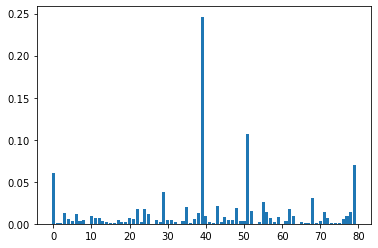

In [ ]:
# define the model
dtc = DecisionTreeClassifier()

# fit the model
dtc.fit(X_train, y_train)

# # perform permutation importance
# results_dtc = permutation_importance(dtc, X_train, y_train, scoring='accuracy', n_repeats=5)

# # get importance
# importance_dtc = results_dtc.importances_mean

# get importance
importance_dtc = dtc.feature_importances_

# summarize feature importance
for i,v in enumerate(importance_dtc):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance_dtc))], importance_dtc)
pyplot.show()

#### Random Forest Feature Importance

Feature: 0, Score: 0.02162
Feature: 1, Score: 0.01727
Feature: 2, Score: 0.01482
Feature: 3, Score: 0.01554
Feature: 4, Score: 0.01536
Feature: 5, Score: 0.04305
Feature: 6, Score: 0.02800
Feature: 7, Score: 0.01026
Feature: 8, Score: 0.02997
Feature: 9, Score: 0.02307
Feature: 10, Score: 0.01648
Feature: 11, Score: 0.01066
Feature: 12, Score: 0.01079
Feature: 13, Score: 0.01393
Feature: 14, Score: 0.01360
Feature: 15, Score: 0.01862
Feature: 16, Score: 0.00666
Feature: 17, Score: 0.01305
Feature: 18, Score: 0.01204
Feature: 19, Score: 0.00924
Feature: 20, Score: 0.01386
Feature: 21, Score: 0.00819
Feature: 22, Score: 0.01592
Feature: 23, Score: 0.01520
Feature: 24, Score: 0.01439
Feature: 25, Score: 0.02986
Feature: 26, Score: 0.00672
Feature: 27, Score: 0.00736
Feature: 28, Score: 0.00750
Feature: 29, Score: 0.02262
Feature: 30, Score: 0.01226
Feature: 31, Score: 0.01030
Feature: 32, Score: 0.00825
Feature: 33, Score: 0.00893
Feature: 34, Score: 0.00941
Feature: 35, Score: 0.01581
Fe

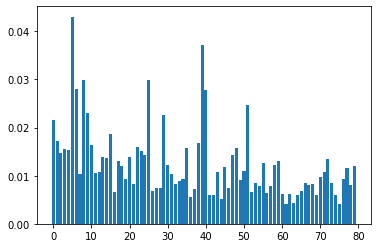

In [ ]:
# define the model
rfc = RandomForestClassifier()

# fit the model
rfc.fit(X_train, y_train)

# # perform permutation importance
# results_rfc = permutation_importance(rfc, X_train, y_train, scoring='accuracy', n_repeats=5)

# # get importance
# importance_rfc = results_rfc.importances_mean

# get importance
importance_rfc = rfc.feature_importances_

# summarize feature importance
for i,v in enumerate(importance_rfc):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance_rfc))], importance_rfc)
pyplot.show()

#### Boosted Tree Feature Importance

Feature: 0, Score: 0.04597
Feature: 1, Score: 0.06666
Feature: 2, Score: 0.05285
Feature: 3, Score: 0.07304
Feature: 4, Score: 0.02631
Feature: 5, Score: 0.03831
Feature: 6, Score: 0.02981
Feature: 7, Score: 0.02690
Feature: 8, Score: 0.01949
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.08939
Feature: 11, Score: 0.00988
Feature: 12, Score: 0.00851
Feature: 13, Score: 0.00669
Feature: 14, Score: 0.01262
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00734
Feature: 18, Score: 0.01016
Feature: 19, Score: 0.01207
Feature: 20, Score: 0.01232
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.01329
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00516
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00796
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.01271
Feature: 30, Score: 0.00555
Feature: 31, Score: 0.00655
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00332
Feature: 35, Score: 0.01164
Fe

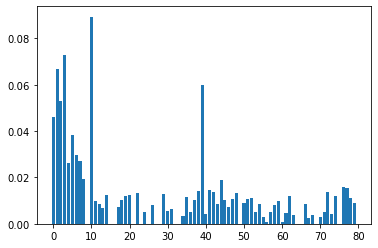

In [ ]:
# define the model
xgbClass =  XGBClassifier()

# fit the model
xgbClass.fit(X_train, y_train)

# # perform permutation importance
# results_xgb = permutation_importance(xgbClass, X_train, y_train, scoring='accuracy', n_repeats=5)

# # get importance
# importance_xgb = results_xgb.importances_mean

# get importance
importance_xgb = xgbClass.feature_importances_

# summarize feature importance
for i,v in enumerate(importance_xgb):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance_xgb))], importance_xgb)
pyplot.show()

#### Rank Ordered Feature Importance (All 3 Tree Based Algorithms)

In [ ]:
tree_scores = {'Feat_Num':list(range(1,81)),
              'Decision_Tree':importance_dtc,
              'Random_Forest':importance_rfc,
              'Boosted_Tree':importance_xgb}
df_tree_scores = pd.DataFrame(tree_scores)

In [ ]:
# Determine the ranks of each record based on the tree scores, then find the avg of those ranks
df_tree_scores['DT_Rank'] = df_tree_scores['Decision_Tree'].rank(method='max', ascending=False)
df_tree_scores['RFC_Rank'] = df_tree_scores['Random_Forest'].rank(method='max', ascending=False)
df_tree_scores['BT_Rank'] = df_tree_scores['Boosted_Tree'].rank(method='max', ascending=False)
df_tree_scores['AVG_Rank'] = df_tree_scores[['DT_Rank', 'RFC_Rank','BT_Rank']].mean(axis=1)
df_tree_scores['Feat_Name'] = X_train.columns

In [ ]:
df_tree_scores_ordered = df_tree_scores.sort_values(['AVG_Rank'])['Feat_Name']

In [ ]:
df_tree_scores.sort_values(['AVG_Rank'])

,Feat_Num,Decision_Tree,Random_Forest,Boosted_Tree,DT_Rank,RFC_Rank,BT_Rank,AVG_Rank,Feat_Name
39,40,0.246261,0.037190,0.059777,1.0,2.0,4.0,2.333333,Cardnum_totalamount1_Amount2
0,1,0.060712,0.021623,0.045968,4.0,10.0,6.0,6.666667,Cardnum_|_zip_totalamount7_Amount2
6,7,0.012013,0.027998,0.029807,20.0,5.0,8.0,11.000000,Cardnum_|_zip_totalamount14_Amount2
29,30,0.037276,0.022622,0.012706,5.0,9.0,21.0,11.666667,Merchnum_totalamount1_Amount2
3,4,0.012296,0.015536,0.073042,19.0,18.0,2.0,13.000000,Cardnum_|_merchnum_totalamount14_Amount2
51,52,0.106899,0.024624,0.010543,2.0,7.0,30.0,13.000000,Cardnum_max14_Amount2
10,11,0.008796,0.016482,0.089390,25.0,14.0,1.0,13.333333,Cardnum_|_merchnum_totalamount1_Amount2
22,23,0.018189,0.015924,0.013289,11.0,15.0,19.0,15.000000,Cardnum_|_state_max14_Amount2
48,49,0.018684,0.015705,0.013187,10.0,17.0,20.0,15.666667,Cardnum_max7_Amount2
38,39,0.012814,0.016735,0.014157,18.0,13.0,16.0,15.666667,Merchnum_totalamount3_Amount2


In [ ]:
df_tree_scores.sort_values(['AVG_Rank']).to_csv('df_tree_scores_results.csv')

## Model Algorithms

### Boosted Trees
Train a boosted tree with the selected variables

In [ ]:
top25vars = df_tree_scores.sort_values(['AVG_Rank']).Feat_Name[:25]
top20vars = df_tree_scores.sort_values(['AVG_Rank']).Feat_Name[:20]
top30vars = df_tree_scores.sort_values(['AVG_Rank']).Feat_Name[:30]
df_top30vars = df_KSFDR[top30vars]
df_top21vars = df_KSFDR[top30vars]
df_top25vars = df_KSFDR[top25vars]
df_top20vars = df_KSFDR[top20vars]

In [ ]:
# Create Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(df_top30vars, df_KSFDR['Fraud'], test_size=0.3, train_size=0.7)

In [ ]:
# Get the OOT data
X_oot = df_oot[consolidated_dict['top30'].Feat_Name]
y_oot = df_oot['Fraud']

# X_oot = df_oot[top20vars]
# y_oot = df_oot['Fraud']

In [ ]:
sum_pos = sum(y_train== 1.0)
print(sum_pos)
sum_neg = sum(y_train== 0.0)
print(sum_neg)
ratio = sum_neg / sum_pos
print(ratio)

587
55855
95.15332197614991


#### Initial Results with GridSearchCV
Function Definition Area

In [ ]:
from sklearn.metrics import make_scorer
def custom_FDR(y_true, y_scores):
    res_df = pd.DataFrame({'score':y_scores,'label': y_true}).sort_values(by='score',ascending=False)
    top3_res1 = res_df.head(round(y_true.shape[0]*0.03))
    top3_res2 = res_df.tail(round(y_true.shape[0]*0.03))

#     return np.maximum((top3_res1['label'].sum()/sum(y_true)),(top3_res1['label'].sum()/sum(y_true)))
    return (top3_res1['label'].sum()/sum(y_true))
my_fdr_metric = make_scorer(custom_FDR, greater_is_better=True,needs_proba = True)

In [ ]:
def make_data(model, X_data, y_data):
    fraud_proba = model.predict_proba(X_data)[:, 1]
    fraud_pred = model.predict(X_data)
    curr_data = X_data.copy()
    curr_data.insert(0, 'Fraud', y_data)
    curr_data.insert(1, 'fraud_proba', fraud_proba)
    curr_data.insert(2, 'frad_pred', fraud_pred)
    curr_data = curr_data.sort_values(['fraud_proba'], ascending=False)
    return curr_data

In [ ]:
def fdr(data, topRows):
    topRows_fs = int(round(len(data)*topRows))
    data_topRows = data.head(topRows_fs)
    frauds_current = data_topRows.loc[:,'Fraud']
    bads_all = data.loc[data['Fraud'] == 1]
    FDR = sum(frauds_current) / len(bads_all)
    return FDR

GridSearchCV  caused overfitting.

In [ ]:
# xgbClass =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, n_estimators=800, max_depth=6, scale_pos_weight=ratio)
xgbClass =  XGBClassifier(objective='binary:logistic')

In [ ]:
# Define a set of parameters to test using GridSearchCV
# NOTE: a variety of different parameters were tested (some not shown)
parameters_xgb = {
    'max_depth': range (3, 7, 1),
    'n_estimators': range(600, 900, 200),
    'eta': [0.001, 0.0001, 0.00001],
    'scale_pos_weight':[ratio], 
    'scoring':[my_fdr_metric]}

# parameters_xgb = {
#     'max_depth': range (3, 7, 1),
#     'n_estimators': range(400, 1500, 200),
#     'eta': [0.1, 0.01, 0.001, 0.002, 0.2, 0.3],
#     'scale_pos_weight':[ratio, 1], 
#     'scoring':['accuracy','roc_auc']
# }

In [ ]:
# Instantiate the model with GridSearchCV
xgb_gsCV = GridSearchCV(
    estimator=xgbClass,
    param_grid=parameters_xgb,
    n_jobs = -1,
    cv = 3,
    verbose=True
)

In [ ]:
# Fit GridSearchCV
start_xgbfit=pd.datetime.now()
xgb_gsCV.fit(X_train,y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 35.1min finished


DONE! 0:37:06.987029


In [ ]:
# View the best estimator from GridSearchCV
xgb_gsCV.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.001, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=92.75747508305648,
              scoring=make_scorer(custom_FDR, needs_proba=True), seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# View the best parameters from GridSearchCV
xgb_gsCV.best_params_

{'eta': 0.001,
 'max_depth': 5,
 'n_estimators': 600,
 'scale_pos_weight': 92.75747508305648,
 'scoring': make_scorer(custom_FDR, needs_proba=True)}

In [ ]:
# View the results of GridSearchCV
df_xgb_gsCV = pd.DataFrame.from_dict(xgb_gsCV.cv_results_)
# df_xgb_gsCV.to_csv("df_xgb_gsCV.csv")
df_xgb_gsCV.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,param_scale_pos_weight,param_scoring,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
21,282.051802,1.679179,1.189662,0.121395,1e-05,5,800,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 1e-05, 'max_depth': 5, 'n_estimators':...",0.996758,0.996226,0.997502,0.996829,0.000523,1
4,209.488939,0.589999,1.006986,0.083744,0.001,5,600,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 0.001, 'max_depth': 5, 'n_estimators':...",0.996598,0.996279,0.997608,0.996829,0.000566,1
5,280.793649,1.896140,1.266117,0.069475,0.001,5,800,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 0.001, 'max_depth': 5, 'n_estimators':...",0.996758,0.996226,0.997502,0.996829,0.000523,1
20,223.349348,0.119128,0.936688,0.008936,1e-05,5,600,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 1e-05, 'max_depth': 5, 'n_estimators':...",0.996598,0.996279,0.997608,0.996829,0.000566,1
13,285.930664,2.925059,1.224047,0.017197,0.0001,5,800,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 0.0001, 'max_depth': 5, 'n_estimators'...",0.996758,0.996226,0.997502,0.996829,0.000523,1
12,217.616284,2.475429,1.090873,0.115589,0.0001,5,600,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 0.0001, 'max_depth': 5, 'n_estimators'...",0.996598,0.996279,0.997608,0.996829,0.000566,1
11,237.803846,3.959255,0.977739,0.032849,0.0001,4,800,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 0.0001, 'max_depth': 4, 'n_estimators'...",0.996598,0.996492,0.997236,0.996775,0.000329,7
3,235.609316,1.642838,0.978220,0.081575,0.001,4,800,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 0.001, 'max_depth': 4, 'n_estimators':...",0.996598,0.996492,0.997236,0.996775,0.000329,7
19,251.816939,3.371222,0.986578,0.032717,1e-05,4,800,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 1e-05, 'max_depth': 4, 'n_estimators':...",0.996598,0.996492,0.997236,0.996775,0.000329,7
2,181.050254,3.284566,0.728718,0.019138,0.001,4,600,92.7575,"make_scorer(custom_FDR, needs_proba=True)","{'eta': 0.001, 'max_depth': 4, 'n_estimators':...",0.996439,0.996386,0.997183,0.996669,0.000364,10


In [ ]:
# Calculate the accuracy scores of the model 
train_score = xgb_gsCV.score(X_train, y_train)
print("Training Score:", train_score)
test_score = xgb_gsCV.score(X_test, y_test)
print("Test Score:", test_score)
oot_score = xgb_gsCV.score(X_oot, y_oot)
print("OOT Score:", oot_score)
print("")

# Calculate the ".predict_proba" and make dataframes for all datasets
train_data = make_data(xgb_gsCV, X_train, y_train) 
test_data = make_data(xgb_gsCV, X_test, y_test) 
oot_data = make_data(xgb_gsCV, X_oot, y_oot) 

# Calculate the FDRs
fdr_rate = 0.03
train_FDR = fdr(train_data, fdr_rate)
print("Training FDR:", train_FDR)
test_FDR = fdr(test_data, fdr_rate)
print("Test FDR:", test_FDR)
oot_FDR = fdr(oot_data, fdr_rate)
print("OOT FDR:", oot_FDR)

Training Score: 1.0
Test Score: 0.9970649028524183
OOT Score: 0.9884927979399695

Training FDR: 1.0
Test FDR: 0.9511278195488722
OOT FDR: 0.48044692737430167


### Initial Results via Manual Processing
As a part of the project, we were required to run a model 10 times with each run using a different train_test_split to see the variance in the results.

In [ ]:
top25vars = consolidated_dict['top30'].Feat_Name.iloc[:-5]
top20vars = consolidated_dict['top30'].Feat_Name.iloc[:-10]

df_top30vars = df_KSFDR[consolidated_dict['top30'].Feat_Name]
df_top21vars = df_KSFDR[consolidated_dict['top21'].Feat_Name]
df_top25vars = df_KSFDR[top25vars]
df_top20vars = df_KSFDR[top20vars]

goods = df_KSFDR.loc[df_KSFDR['Fraud'] == 0]
bads = df_KSFDR.loc[df_KSFDR['Fraud'] == 1]

In [ ]:
consolidated_dict['top30'].Feat_Name

0                 Cardnum_totalamount1_Amount2
2                Merchnum_totalamount1_Amount2
3                        Cardnum_max14_Amount2
4                         Cardnum_max7_Amount2
10         Cardnum_|_zip_totalamount14_Amount2
5     Cardnum_|_merchnum_totalamount14_Amount2
11     Cardnum_|_merchnum_totalamount1_Amount2
7      Cardnum_|_merchnum_totalamount3_Amount2
8                Merchnum_totalamount3_Amount2
13               Cardnum_|_state_max14_Amount2
16     Cardnum_|_merchnum_totalamount7_Amount2
14                      Cardnum_mean14_Amount2
9                Cardnum_|_state_max30_Amount2
24          Cardnum_|_zip_totalamount3_Amount2
17                       Merchnum_max7_Amount2
12        Cardnum_|_state_totalamount3_Amount2
21                Cardnum_totalamount0_Amount2
22               Merchnum_totalamount7_Amount2
18        Cardnum_|_state_totalamount1_Amount2
37                 Cardnum_|_zip_max30_Amount2
27            Cardnum_|_merchnum_max14_Amount2
30           

In [ ]:
goods_xgb = df_top30vars.loc[df_KSFDR['Fraud'] == 0]
bads_xgb = df_top30vars.loc[df_KSFDR['Fraud'] == 1]
goods_xgb.head()    

,Cardnum_totalamount1_Amount2,Merchnum_totalamount1_Amount2,Cardnum_max14_Amount2,Cardnum_max7_Amount2,Cardnum_|_zip_totalamount14_Amount2,Cardnum_|_merchnum_totalamount14_Amount2,Cardnum_|_merchnum_totalamount1_Amount2,Cardnum_|_merchnum_totalamount3_Amount2,Merchnum_totalamount3_Amount2,Cardnum_|_state_max14_Amount2,Cardnum_|_merchnum_totalamount7_Amount2,Cardnum_mean14_Amount2,Cardnum_|_state_max30_Amount2,Cardnum_|_zip_totalamount3_Amount2,Merchnum_max7_Amount2,Cardnum_|_state_totalamount3_Amount2,Cardnum_totalamount0_Amount2,Merchnum_totalamount7_Amount2,Cardnum_|_state_totalamount1_Amount2,Cardnum_|_zip_max30_Amount2,Cardnum_|_merchnum_max14_Amount2,Merchnum_max3_Amount2,Merchnum_mean1_Amount2,Merchnum_max0_Amount2,Cardnum_totalamount14_Amount2,Cardnum_median1_Amount2,Cardnum_|_merchnum_totalamount30_Amount2,Cardnum_totalamount3_Amount2,Cardnum_|_state_max7_Amount2,Cardnum_|_zip_totalamount0_Amount2
3338,0.077781,-0.176272,0.221233,0.014491,0.275871,0.287205,-0.065265,-0.072258,-0.132979,0.314690,0.310921,0.005404,0.207831,-0.075880,0.139100,-0.098932,-0.118952,0.374560,-0.080741,0.413778,0.484199,-0.267411,-0.083633,-0.165099,0.491199,-0.046684,0.243379,0.073878,0.392984,-0.075566
3339,-0.079228,-0.251945,-0.290866,-0.189586,-0.065744,-0.063571,-0.147170,-0.113646,-0.155002,-0.496226,-0.087938,-0.740127,-0.535907,-0.114007,-0.577698,-0.136547,-0.214860,-0.225503,-0.161897,-0.477703,-0.444209,-0.521970,-0.513240,-0.495903,-0.274008,-0.051292,-0.096764,-0.110870,-0.469388,-0.201031
3340,0.316441,-0.118910,0.701487,0.942893,0.358683,0.370445,-0.003178,-0.010822,-0.185717,-0.044831,-0.024907,0.098686,-0.121907,-0.014539,-0.389084,0.051844,-0.136886,-0.309665,-0.019221,0.018538,0.072588,-0.312879,-0.265288,-0.226958,1.171268,-0.140108,0.324096,1.135972,-0.151732,-0.099027
3341,-0.078589,-0.251113,-0.290866,-0.189586,-0.064879,-0.062702,-0.146269,-0.112755,-0.154298,-0.496226,-0.087055,-0.740228,-0.535907,-0.113117,-0.577698,-0.135669,-0.213805,-0.224927,-0.161005,-0.477703,-0.444209,-0.521970,-0.513730,-0.495903,-0.273623,-0.546291,-0.095921,-0.110278,-0.469388,-0.199651
3342,-0.192924,-0.249207,-0.640811,-0.588944,-0.188450,-0.179518,-0.144206,-0.150372,-0.273794,-0.495489,-0.163073,-0.728062,-0.535231,-0.153873,-0.321095,-0.175878,-0.211389,-0.322933,-0.158960,-0.476893,-0.443365,-0.449815,-0.497693,-0.483932,-0.398212,-0.528210,-0.209195,-0.244732,-0.468604,-0.196491


#### Run a Boosted Tree 10 Times
The purpose of this loop was to run a boosted tree 10 times with a differen train_test_split for each iteration. The results are saved in a dictionary for further review.

During the project, we manually changed the parameters to see how they performed. We then manually saved the set of 10 runs in a different dictionary.

In [ ]:
time_results=pd.datetime.now()
X_goods_xgb = df_top30vars.loc[df_KSFDR['Fraud'] == 0]
y_goods_xgb = df_KSFDR.loc[df_KSFDR['Fraud'] == 0, 'Fraud']
X_bads_xgb = df_top30vars.loc[df_KSFDR['Fraud'] == 1]
y_bads_xgb = df_KSFDR.loc[df_KSFDR['Fraud'] == 1, 'Fraud']
down_goods_size = int(len(goods_xgb)*.75) 
# down_goods_size = int(len(bads_xgb))


results_dict={}
oot_FDR_list=[]
train_FDR_list=[]
test_FDR_list=[]
for num in range(1,11):
    curr_time=pd.datetime.now()
    curr_model_name = "xgb_" + str(num)
    
    results_dict[curr_model_name]={'scores':{},
                                   'data':{},
                                   'FDR':{}
                                  }

    # Downsample majority class
    X_goods_temp = resample(X_goods_xgb, replace=False, n_samples=down_goods_size)
    y_goods_temp = y_goods_xgb.loc[X_goods_temp.index]
    
    # Create Train and Test sets
    X_train_goods, X_test_goods, y_train_goods, y_test_goods = train_test_split(X_goods_temp, y_goods_temp, test_size=0.3, train_size=0.7)
    X_train_bads, X_test_bads, y_train_bads, y_test_bads = train_test_split(X_bads_xgb, y_bads_xgb, test_size=0.3, train_size=0.7)
    X_train = pd.concat([X_train_goods, X_train_bads])
    X_test = pd.concat([X_test_goods, X_test_bads])
    y_train = pd.concat([y_train_goods, y_train_bads])
    y_test = pd.concat([y_test_goods, y_test_bads])
    
    # Get the OOT data
    X_oot = df_oot[consolidated_dict['top30'].Feat_Name]
    y_oot = df_oot['Fraud']
    
    # Calculate ratio for scale_pos_weight parameter
    sum_pos = sum(y_train== 1.0)
    sum_neg = sum(y_train== 0.0)
    ratio = sum_neg / sum_pos
    
    ### NOTE: The parameters were manually changed for the project since we were manually testing different ideas (GridSearchCV caused overfitting)
    # Train a model
    start_xgbfit=pd.datetime.now()
    vars()[curr_model_name] =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                               n_estimators=1500, max_depth=2, scale_pos_weight=ratio,
                               booster='gbtree')
    vars()[curr_model_name].fit(X_train, y_train)
    print("Done training!", pd.datetime.now()-start_xgbfit)
    
    # Calculate the accuracy scores of the model 
    train_score = vars()[curr_model_name].score(X_train, y_train)
    test_score = vars()[curr_model_name].score(X_test, y_test)
    oot_score = vars()[curr_model_name].score(X_oot, y_oot)
    
    # Save the accuracy scores of the model
    results_dict[curr_model_name]['scores']['train_score'] = train_score
    results_dict[curr_model_name]['scores']['test_score'] = test_score
    results_dict[curr_model_name]['scores']['oot_score'] = oot_score
    
    # Calculate the ".predict_proba" and make dataframes for all datasets
    train_data = make_data(vars()[curr_model_name], X_train, y_train) 
    test_data = make_data(vars()[curr_model_name], X_test, y_test) 
    oot_data = make_data(vars()[curr_model_name], X_oot, y_oot) 
    
    # Save all the dataframes for the model
    results_dict[curr_model_name]['data']['train_data'] = train_data
    results_dict[curr_model_name]['data']['test_data'] = test_data
    results_dict[curr_model_name]['data']['oot_data'] = oot_data
    
    # Calculate the FDRs
    train_FDR = fdr(train_data, 0.03)
    test_FDR = fdr(test_data, 0.03)
    oot_FDR = fdr(oot_data, 0.03)
    train_FDR_list.append(train_FDR)
    test_FDR_list.append(test_FDR)
    oot_FDR_list.append(oot_FDR)
    print('OOT FDR', oot_FDR)
    
    # Save the FDRs
    results_dict[curr_model_name]['FDR']['train_FDR'] = train_FDR
    results_dict[curr_model_name]['FDR']['test_FDR'] = test_FDR
    results_dict[curr_model_name]['FDR']['oot_FDR'] = oot_FDR
    
    print("Done with:",curr_model_name, ";  time:",pd.datetime.now()-curr_time,'\n')

print("DONE WITH ALL!", pd.datetime.now()-time_results)
print('Avg OOT FDR', statistics.mean(oot_FDR_list))

Done training! 0:01:50.971035
OOT FDR 0.5418994413407822
Done with: xgb_371 ;  time: 0:01:56.452756 

Done training! 0:01:58.798694
OOT FDR 0.5195530726256983
Done with: xgb_372 ;  time: 0:02:04.699607 

Done training! 0:01:56.468470
OOT FDR 0.5083798882681564
Done with: xgb_373 ;  time: 0:02:01.717486 

Done training! 0:02:02.828474
OOT FDR 0.553072625698324
Done with: xgb_374 ;  time: 0:02:08.460225 

Done training! 0:02:02.270879
OOT FDR 0.5251396648044693
Done with: xgb_375 ;  time: 0:02:08.094378 

Done training! 0:02:07.612490
OOT FDR 0.5195530726256983
Done with: xgb_376 ;  time: 0:02:14.330837 

Done training! 0:02:02.578860
OOT FDR 0.5418994413407822
Done with: xgb_377 ;  time: 0:02:08.184658 

Done training! 0:02:07.604587
OOT FDR 0.5195530726256983
Done with: xgb_378 ;  time: 0:02:13.381394 

Done training! 0:02:05.455949
OOT FDR 0.5307262569832403
Done with: xgb_379 ;  time: 0:02:11.055967 

Done training! 0:02:06.827699
OOT FDR 0.5195530726256983
Done with: xgb_380 ;  time

We manually saved each of the 10 iterations that were run. 

In [ ]:
# # During the first set of 10 runs, this dictionary needs to be instantiated. Comment it out after the first set.
# results_report={}

In [ ]:
# This is where we manually save the set of 10 runs. Simply change the number to whatever you need (e.g. 1 to infinity)
results_report[37]={'results_dict':results_dict.copy(),
                  'avg_train_fdr':statistics.mean(train_FDR_list),
                  'avg_test_fdr':statistics.mean(test_FDR_list),
                  'avg_oot_fdr':statistics.mean(oot_FDR_list)}

In [ ]:
# Have a quick look at the averaged FDR results
print(results_report[37]['avg_train_fdr'])
print(results_report[37]['avg_test_fdr'])
print(results_report[37]['avg_oot_fdr'])

0.9031301482701812
0.8651340996168582
0.5279329608938548


In [ ]:
# Have a quick look at the results of the 10 runs
for model in results_dict.keys():
    print(model)
    print(results_dict[model]['scores'])
    print(results_dict[model]['FDR'])
    print("")

xgb_1
{'train_score': 0.9631146576277569, 'test_score': 0.9578207381370826, 'oot_score': 0.9593626780397522}
{'train_FDR': 0.8731466227347611, 'test_FDR': 0.8045977011494253, 'oot_FDR': 0.5865921787709497}

xgb_2
{'train_score': 0.9597250664971871, 'test_score': 0.9588093145869947, 'oot_score': 0.953246962259596}
{'train_FDR': 0.8879736408566722, 'test_FDR': 0.8390804597701149, 'oot_FDR': 0.5698324022346368}

xgb_3
{'train_score': 0.9599604547701434, 'test_score': 0.9590839191564148, 'oot_score': 0.952925082481693}
{'train_FDR': 0.8896210873146623, 'test_FDR': 0.8160919540229885, 'oot_FDR': 0.5642458100558659}

xgb_4
{'train_score': 0.9572770284584422, 'test_score': 0.9553492970123023, 'oot_score': 0.9508328639253238}
{'train_FDR': 0.8747940691927513, 'test_FDR': 0.8275862068965517, 'oot_FDR': 0.5642458100558659}

xgb_5
{'train_score': 0.9581008874137891, 'test_score': 0.9567772407732865, 'oot_score': 0.9489015852579061}
{'train_FDR': 0.8813838550247117, 'test_FDR': 0.8314176245210728,

In [ ]:
# View the average FDR results for the results stored in the results_report dictionary
train_fdr_result=[]
test_fdr_result=[]
oot_fdr_result=[]
for key in results_report.keys():
    train_fdr_result.append(results_report[key]['avg_train_fdr'])
    test_fdr_result.append(results_report[key]['avg_test_fdr'])
    oot_fdr_result.append(results_report[key]['avg_oot_fdr'])
    
    print(key)
    print(results_report[key]['avg_train_fdr'])
    print(results_report[key]['avg_test_fdr'])
    print(results_report[key]['avg_oot_fdr'])
    print("")

1
0.8838550247116969
0.8226053639846743
0.570391061452514

2
0.9377265238879736
0.8662835249042146
0.5273743016759777

3
0.9752883031301482
0.8842911877394636
0.47039106145251397

4
0.9181219110378913
0.8494252873563218
0.5536312849162011

5
0.956177924217463
0.8954022988505748
0.5078212290502794

6
0.9927512355848435
0.8931034482758621
0.42402234636871505

7
0.9342668863261944
0.8735632183908046
0.5430167597765363

8
0.9789126853377266
0.8931034482758621
0.5150837988826815

9
1.0
0.9103448275862069
0.4435754189944134

10
0.7008237232289951
0.6743295019157088
0.4983240223463687

11
0.7700164744645799
0.717624521072797
0.46033519553072627

12
0.8400329489291598
0.7233716475095785
0.4145251396648045

13
0.7082372322899506
0.667816091954023
0.4983240223463687

14
0.7952224052718286
0.728735632183908
0.4513966480446927

15
0.8622734761120263
0.7459770114942529
0.39608938547486033

16
0.7237232289950577
0.6812260536398468
0.5083798882681564

17
0.8059308072487644
0.7295019157088123
0.462569

In [ ]:
# This was a very manual way to create the necessary table for the project report
num_trees=[600,600,600,800,800,800,1000,1000,1000,600,600,600,800,800,800,1000,1000,1000,600,600,800,800,1000,1000,600,600,800,800,1000,1000,600,600,800,800,1000,1000,1500]
max_depth=[3,4,5,3,4,5,3,4,5,3,4,5,3,4,5,3,4,5,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,2]
learning_rate=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,1.0,1.0,1.0,1.0,1.0,1.0,0.1,0.1,0.1,0.1,0.1,0.1,0.01]

df_results_report = pd.DataFrame.from_dict({'Num of Trees':num_trees,
                                           'Max Depth':max_depth,
                                           'Learning Rate':learning_rate,
                                           'AVG TRAIN FDR':train_fdr_result,
                                           'AVG TEST FDR':test_fdr_result,
                                           'AVG OOT FDR':oot_fdr_result})
df_results_report

,Num of Trees,Max Depth,Learning Rate,AVG TRAIN FDR,AVG TEST FDR,AVG OOT FDR
0,600,3,0.0100,0.883855,0.822605,0.570391
1,600,4,0.0100,0.937727,0.866284,0.527374
2,600,5,0.0100,0.975288,0.884291,0.470391
3,800,3,0.0100,0.918122,0.849425,0.553631
4,800,4,0.0100,0.956178,0.895402,0.507821
5,800,5,0.0100,0.992751,0.893103,0.424022
6,1000,3,0.0100,0.934267,0.873563,0.543017
7,1000,4,0.0100,0.978913,0.893103,0.515084
8,1000,5,0.0100,1.000000,0.910345,0.443575
9,600,3,0.0010,0.700824,0.674330,0.498324


In [ ]:
# # Save the table for the report
# df_results_report.to_csv('xgb_results_report.csv')

### Neural Networks

#### Cross Validation results for Keras neural net

#### dataset choice

In [ ]:
max_no_features = 30 
current_columns = col_KS_FDR
# current_columns = cols_WD_ED_FS
# current_columns = svc_L1_cols
# current_columns = rfe_cols80
# current_columns = DT_RF_XGB_cols_80

# split into input (X) and output (Y) variables
X = feature_select_df[current_columns[0:max_no_features]].values
Y = feature_select_df['Fraud'].values
X_oot = OOT_df[current_columns[0:max_no_features]].values
y_oot = OOT_df["Fraud"].values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_oot = scaler.fit_transform(X_oot)
# verify results
X_oot.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
X = np.clip(X, -5, 5)
X_oot = np.clip(X_oot, -5, 5)

array([-0.16414568, -0.14985067, -0.15899912, -0.1750719 , -0.14671968,
       -0.17080219, -0.1832474 , -0.20344669, -0.15475512, -0.1406809 ,
       -0.14282392, -0.20497747, -0.24629319, -0.21879987, -0.4616672 ,
       -0.18981744, -0.199151  , -0.19177528, -0.4871884 , -0.48009136,
       -0.45253676, -0.43079224, -0.50895226, -0.44652182, -0.47449493,
       -0.23871565, -0.42685482, -0.44010672, -0.45556587, -0.24424374],
      dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from keras.optimizers import SGD
from keras.optimizers import Adam

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# import regularizer
from keras.regularizers import l1 ,l2

# ----------- sampling minority class ----------------
# neg0, pos0 = np.bincount(Y)
# print('Or count of neg:',neg0,'of pos',pos0)
# # define pipeline
# over = SMOTE(sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# # transform the dataset
# X, Y = pipeline.fit_resample(X, Y)
# -----------------------------------------------------

neg, pos = np.bincount(Y)
total = neg + pos

print('New count of neg:',neg,'of pos',pos)

# define opt function----------------------------------
# sgd = SGD(lr=0.001)#, decay=1e-6, momentum=0.9, nesterov=True)
# lr = [1, 0.1, 0.0.1, 0.001, 0.0001] 0.001 is default
adam_par = Adam(learning_rate= 0.0005)#, beta_1=0.9, beta_2=0.999, amsgrad=False)
# # --------------------------------------------------------

# instantiate regularizer----------------------------------
reg_l1 = l1(0.1)
reg_l2 = l2(5e-2)
# # --------------------------------------------------------

class_weights = {0: 0.5, 1: 8.5}
# # optimal class weights-----------------------------------
# weight_for_0 = (1 / neg)*(total)/2.0 
# weight_for_1 = (1 / pos)*(total)/2.0
# class_weights_opt = {0: weight_for_0, 1: weight_for_1}
# # --------------------------------------------------------
DROPOUT_RATE = 0.25

initial_bias = tf.keras.initializers.Constant(np.log([pos/neg]))

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=8, shuffle=True)
# sskfold = StratifiedShuffleSplit(n_splits=5, test_size=0.5)

cvscores_FDR_train = []
cvscores_FDR_test = []
cvscores_FDR_oot = []

start_time = pd.datetime.now()
for train, test in kfold.split(X, Y):
# for train, test in sskfold.split(X, Y):

    model = Sequential()
    model.add(Dense(20, input_dim=X.shape[1], activation='relu'))#, activity_regularizer=reg_l2))
#     model.add(Dropout(DROPOUT_RATE))
#     ---------------added hidden layers---------------------
#     model.add(Dense(30, activation='relu'))#, activity_regularizer=reg_l2))
#     model.add(Dropout(DROPOUT_RATE))
#     model.add(Dense(10, activation='relu'))#, activity_regularizer=reg_l1))
#     model.add(Dropout(DROPOUT_RATE))
#     model.add(Dense(2, activation='tanh'))#, activity_regularizer=reg_l1))
#     model.add(Dropout(DROPOUT_RATE))
#     model.add(Dense(5, activation='tanh'))#, activity_regularizer=reg_l1))
#     model.add(Dropout(DROPOUT_RATE))
# ----------------------------------------------------
    model.add(Dense(1, activation='sigmoid'))#,
#                          bias_initializer=initial_bias))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=adam_par, metrics=[METRICS])
    # Fit the model
    model.fit(X[train], Y[train], epochs=300, batch_size=2048, verbose=0,class_weight=class_weights)

    y_train_pred = np.squeeze(model.predict(X[train], verbose=0))
    y_test_pred = np.squeeze(model.predict(X[test], verbose=0))
    y_oot_pred = np.squeeze(model.predict(X_oot, verbose=0))

    FDR_train = 100*get_FDR(y_train_pred, Y[train])
    FDR_test = 100*get_FDR(y_test_pred, Y[test])
    FDR_OOT = 100*get_FDR(y_oot_pred,y_oot)
    
    cvscores_FDR_train.append(FDR_train)
    cvscores_FDR_test.append(FDR_test)
    cvscores_FDR_oot.append(FDR_OOT)
    print('Train FDR:',FDR_train,'Test FDR:',FDR_test, 'OOT FDR',FDR_OOT)

print("Train scores: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_FDR_train), np.std(cvscores_FDR_train)))
print("Test scores: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_FDR_test), np.std(cvscores_FDR_test)))
print("OOT scores: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_FDR_oot), np.std(cvscores_FDR_oot)))

print('duration: ', pd.datetime.now() - start_time)

New count of neg: 79764 of pos 868
Train FDR: 80.65789473684211 Test FDR: 73.14814814814815 OOT FDR 56.424581005586596
Train FDR: 81.05263157894737 Test FDR: 76.85185185185185 OOT FDR 54.18994413407822
Train FDR: 80.52631578947368 Test FDR: 81.48148148148148 OOT FDR 51.39664804469274
Train FDR: 80.13157894736842 Test FDR: 75.92592592592592 OOT FDR 52.513966480446925
Train FDR: 80.50065876152833 Test FDR: 77.06422018348624 OOT FDR 56.424581005586596
Train FDR: 79.97364953886694 Test FDR: 81.65137614678899 OOT FDR 53.072625698324025
Train FDR: 80.50065876152833 Test FDR: 77.98165137614679 OOT FDR 56.98324022346368
Train FDR: 79.31488801054019 Test FDR: 85.3211009174312 OOT FDR 54.7486033519553
Train scores: 80.33% (+/- 0.49%)
Test scores: 78.68% (+/- 3.63%)
OOT scores: 54.47% (+/- 1.91%)
duration:  0:53:41.132467


## Required Plots

In [ ]:
# Import the datasets from Mrinal
df_pred_all = pd.read_csv('trn_tst_oot.csv').sort_values('Recnum', ascending=True)
df_pred_trn_test = pd.read_csv('trn_tst.csv').sort_values('Predict Proba', ascending=False)
df_pred_trn = pd.read_csv('train.csv').sort_values('Predict Proba', ascending=False)
df_pred_tst = pd.read_csv('test.csv').sort_values('Predict Proba', ascending=False)
df_pred_oot = pd.read_csv('oot.csv').sort_values('Predict Proba', ascending=False)

In [ ]:
# Get the Recnum, fraud scores (Predict Proba), and predicted value from the imported datasets
df_pred_all_scores = df_pred_all[['Recnum','Predict Proba','Predicted']]
df_pred_all_scores

,Recnum,Predict Proba,Predicted
58853,3345,0.004879,0
29494,3346,0.001278,0
61662,3347,0.003077,0
29338,3348,0.001278,0
10787,3349,0.001270,0
...,...,...,...
93054,96749,0.001272,0
93055,96750,0.001907,0
93056,96751,0.002581,0
93057,96752,0.007735,0


In [ ]:
# Merge the fraud score info (df_pred_all_scores) with the original dataset (df_original)
df_orig_scored = pd.merge(df_original.copy(), df_pred_all_scores, how='outer', on='Recnum')
df_orig_scored

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Predict Proba,Predicted
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,NaN,NaN
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,NaN,NaN
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0,0.001272,0.0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0,0.001907,0.0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0,0.002581,0.0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,0.007735,0.0


In [ ]:
# Merge the fraud score info (df_pred_all_scores) with the variables we created (df_final)
df_final_scored = pd.merge(df_final.copy(), df_pred_all_scores, how='outer', on='Recnum')
df_final_scored

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card-merch,card-zip,card-state,Cardnum_freq0_Date,Cardnum_freq1_Date,Cardnum_freq3_Date,Cardnum_freq7_Date,Cardnum_freq14_Date,Cardnum_freq30_Date,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq3_Date,Merchnum_freq7_Date,Merchnum_freq14_Date,Merchnum_freq30_Date,card-merch_freq0_Date,card-merch_freq1_Date,card-merch_freq3_Date,card-merch_freq7_Date,card-merch_freq14_Date,card-merch_freq30_Date,card-zip_freq0_Date,card-zip_freq1_Date,card-zip_freq3_Date,card-zip_freq7_Date,card-zip_freq14_Date,card-zip_freq30_Date,card-state_freq0_Date,card-state_freq1_Date,card-state_freq3_Date,card-state_freq7_Date,card-state_freq14_Date,card-state_freq30_Date,Cardnum_0_dayfreq_div_7_dayfreq_velchange,Cardnum_0_dayfreq_div_14_dayfreq_velchange,Cardnum_0_dayfreq_div_30_dayfreq_velchange,Cardnum_1_dayfreq_div_7_dayfreq_velchange,Cardnum_1_dayfreq_div_14_dayfreq_velchange,Cardnum_1_dayfreq_div_30_dayfreq_velchange,Merchnum_0_dayfreq_div_7_dayfreq_velchange,Merchnum_0_dayfreq_div_14_dayfreq_velchange,Merchnum_0_dayfreq_div_30_dayfreq_velchange,Merchnum_1_dayfreq_div_7_dayfreq_velchange,Merchnum_1_dayfreq_div_14_dayfreq_velchange,Merchnum_1_dayfreq_div_30_dayfreq_velchange,card-merch_0_dayfreq_div_7_dayfreq_velchange,card-merch_0_dayfreq_div_14_dayfreq_velchange,card-merch_0_dayfreq_div_30_dayfreq_velchange,card-merch_1_dayfreq_div_7_dayfreq_velchange,card-merch_1_dayfreq_div_14_dayfreq_velchange,card-merch_1_dayfreq_div_30_dayfreq_velchange,card-zip_0_dayfreq_div_7_dayfreq_velchange,card-zip_0_dayfreq_div_14_dayfreq_velchange,card-zip_0_dayfreq_div_30_dayfreq_velchange,card-zip_1_dayfreq_div_7_dayfreq_velchange,card-zip_1_dayfreq_div_14_dayfreq_velchange,card-zip_1_dayfreq_div_30_dayfreq_velchange,card-state_0_dayfreq_div_7_dayfreq_velchange,card-state_0_dayfreq_div_14_dayfreq_velchange,card-state_0_dayfreq_div_30_dayfreq_velchange,card-state_1_dayfreq_div_7_dayfreq_velchange,card-state_1_dayfreq_div_14_dayfreq_velchange,card-state_1_dayfreq_div_30_dayfreq_velchange,Predict Proba,Predicted
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,51421904395509006296254,514219043938118,5142190439TN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,NaN,NaN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,514218397361003026333,51421839731803,5142183973MA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,NaN,NaN
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,51421317214503082993600,514213172120706,5142131721MD,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,NaN,NaN
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,51421484525509006296254,514214845238118,5142148452TN,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,NaN,NaN
4,5,5142190439,

In [ ]:
# Find a Recnum in the test results that had values of 1 for Predicted, Predict Proba (fraud score, and Fraud (true value)
tst_fraud = df_pred_tst.loc[(df_pred_tst['Predicted']==1) & (df_pred_tst['Fraud']==1) & (df_pred_tst['Predict Proba']==1.0)]
tst_fraud_recnums = tst_fraud['Recnum']
tst_fraud

,Recnum,Predicted,Predict Proba,Fraud
452,59934,1,1.0,1
8271,59720,1,1.0,1
10091,59999,1,1.0,1
10099,59918,1,1.0,1
17431,59911,1,1.0,1
8320,70608,1,1.0,1
12496,60028,1,1.0,1
13576,31294,1,1.0,1
197,62535,1,1.0,1
14499,70756,1,1.0,1


In [ ]:
# Determine the Recnum values in the original dataset that match what we wanted for tst_fraud_recnums (see previous cell)
df_tst_fraud = df_orig_scored.loc[df_orig_scored['Recnum'].isin(tst_fraud_recnums)]
print(df_tst_fraud['Cardnum'].unique())
print(df_tst_fraud['Merchnum'].unique())

[5142179617 5142271065 5142111125 5142138135 5142182128 5142220919
 5142183973]
['253052983001' '4620009957157' '5725000466504' '4620009750086'
 '900009045549' '8730008064698' '3831009006589' '17519283486'
 '6848556518938' '5900000064440' '6005030600003']


In [ ]:
# View the fraud score information and the variables for the different Merchnum values displayed above
# 5725000466504, 4353000719908
merchnum_to_plot = df_final_scored.loc[df_final_scored['Merchnum']=='4353000719908']
merchnum_to_plot = merchnum_to_plot[['Cardnum','Merchnum','Date','Predict Proba','Merchnum_freq0_Date','Merchnum_freq1_Date','Merchnum_freq7_Date','Merchnum_freq30_Date']]
merchnum_to_plot['Predict Proba'].fillna(0, inplace=True)
merchnum_to_plot

,Cardnum,Merchnum,Date,Predict Proba,Merchnum_freq0_Date,Merchnum_freq1_Date,Merchnum_freq7_Date,Merchnum_freq30_Date
23,5142217905,4353000719908,2010-01-01,0.000000,1,1,1,1
157,5142162882,4353000719908,2010-01-03,0.000000,1,1,2,2
183,5142217905,4353000719908,2010-01-03,0.000000,2,2,3,3
198,5142162882,4353000719908,2010-01-03,0.000000,3,3,4,4
248,5142137916,4353000719908,2010-01-04,0.000000,1,4,5,5
...,...,...,...,...,...,...,...,...
96174,5142146217,4353000719908,2010-12-30,0.001304,1,3,10,101
96209,5142190418,4353000719908,2010-12-30,0.001278,2,4,11,102
96268,5142178848,4353000719908,2010-12-30,0.001289,3,5,12,103
96316,5142217905,4353000719908,2010-12-30,0.001269,4,6,13,104


In [ ]:
# Create a dataframe for the selected Merchnum to use with the presentation slide
merchnum_slide = df_orig_scored.loc[(df_orig_scored['Merchnum']=='4353000719908') & (df_orig_scored['Fraud']==1)]
merchnum_slide.rename(columns={'Predict Proba':'Fraud Score'}, inplace=True)
merchnum_slide

C:\Users\chrissy\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Fraud Score,Predicted
19995,19996,5142214614,2010-03-20,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,4335.50,1,0.855913,1.0
39770,39771,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1938.06,1,0.007318,0.0
39805,39806,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1904.83,1,0.059794,0.0
39815,39816,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1698.47,1,0.322869,0.0
39832,39833,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1748.86,1,0.675340,1.0
39834,39835,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1748.07,1,0.880356,1.0
39847,39848,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1859.48,1,0.887596,1.0
39853,39854,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1895.07,1,0.916882,1.0
39858,39859,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1697.09,1,0.962935,1.0
39866,39867,5142116864,2010-05-27,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1648.98,1,0.976799,1.0


In [ ]:
# # Save the Merchnum dataframe for the presentation slide
# merchnum_slide.to_csv('merchnum_slide.csv')

Text(0.5, 1.0, 'Merchnum 4353000719908')

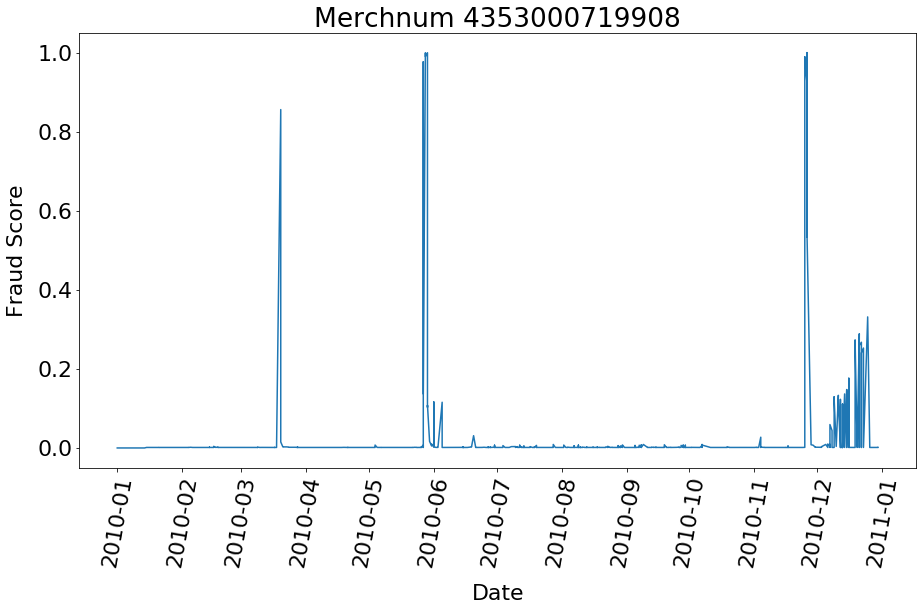

In [ ]:
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['font.size'] = 22
fig = plt.figure()
ax = plt.axes()

plt.plot(merchnum_to_plot['Date'], merchnum_to_plot['Predict Proba'])
months = mdates.MonthLocator()  # every month
ax.xaxis.set_major_locator(months)
plt.xticks(rotation='80')
plt.xlabel('Date', labelpad=15)
plt.ylabel('Fraud Score', labelpad=10)
plt.title("Merchnum 4353000719908")

Text(0, 0.5, 'Fraud Score')

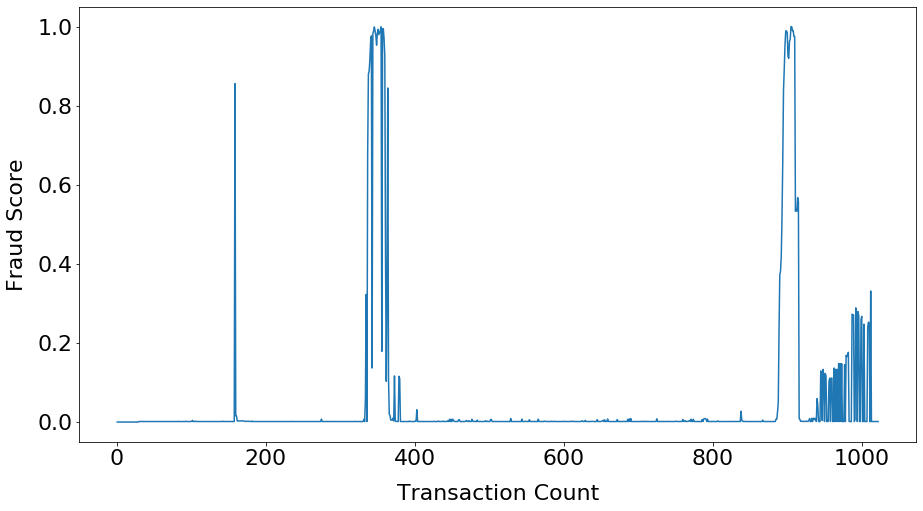

In [ ]:
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['font.size'] = 22
fig = plt.figure()
ax = plt.axes()

plt.plot(range(1, len(merchnum_to_plot)+1), merchnum_to_plot['Predict Proba'])
# plt.xticks()
plt.xlabel('Transaction Count', labelpad=15)
plt.ylabel('Fraud Score', labelpad=10)
# plt.title("Merchnum 5725000466504 (CDWG, Inc.)")

In [ ]:
# Find the burst of activity
merchnum_slide.groupby(['Date'])['Merchnum'].count()

Date
2010-03-20     1
2010-05-27     9
2010-05-28    11
2010-05-29     7
2010-11-17     2
2010-11-25    17
2010-11-26    15
2010-12-03     3
2010-12-05     1
2010-12-06     3
2010-12-07     2
2010-12-08     1
2010-12-09     2
2010-12-11     2
2010-12-12     2
2010-12-13     4
2010-12-14     3
2010-12-15     2
2010-12-16     6
2010-12-19     3
2010-12-21     5
2010-12-22     3
2010-12-23     2
2010-12-25     1
Name: Merchnum, dtype: int64

In [ ]:
# Find the burst of activity
merchnum_to_plot.groupby(['Date'])['Merchnum'].count()

Date
2010-01-01     1
2010-01-03     3
2010-01-04     2
2010-01-05     3
2010-01-06     2
2010-01-07     1
2010-01-10     1
2010-01-11     4
2010-01-12     6
2010-01-13     1
2010-01-14     5
2010-01-15     1
2010-01-16     1
2010-01-18     3
2010-01-19     2
2010-01-20     5
2010-01-21     5
2010-01-24     3
2010-01-25     1
2010-01-26     3
2010-01-27     4
2010-01-28     5
2010-01-29     1
2010-01-31     3
2010-02-01     2
2010-02-02     5
2010-02-03     3
2010-02-04     6
2010-02-05     1
2010-02-06     2
2010-02-07     1
2010-02-08     1
2010-02-09     1
2010-02-10     3
2010-02-14     3
2010-02-15     3
2010-02-16     5
2010-02-17     3
2010-02-18     3
2010-02-19     2
2010-02-23     3
2010-02-25     3
2010-02-28     3
2010-03-02     3
2010-03-03     3
2010-03-06     3
2010-03-07     6
2010-03-08     3
2010-03-09     6
2010-03-10     1
2010-03-11     1
2010-03-13     1
2010-03-14     2
2010-03-16     5
2010-03-17     4
2010-03-18     1
2010-03-20     3
2010-03-21     6
2010-03-2

In [ ]:
# Locate additional information regarding bursts of activity for the presentation
merchnum_slide2 = df_orig_scored.loc[(df_orig_scored['Date'] >= '2010-11-25') & (df_orig_scored['Date'] <= '2010-11-27') & (df_orig_scored['Merchnum']=='4353000719908')]
merchnum_slide2.rename(columns={'Predict Proba':'Fraud Score'}, inplace=True)
merchnum_slide2[['Date','Merch description','Fraud','Predicted','Fraud Score']]

,Date,Merch description,Fraud,Predicted,Fraud Score
89364,2010-11-25,AMAZON.COM *SUPERSTOR,1,0.0,0.001508
89365,2010-11-25,ACI*AMAZON.COM INC,1,0.0,0.007318
89366,2010-11-25,AMAZON.COM *SUPERSTOR,1,0.0,0.007318
89368,2010-11-25,AMAZON.COM *SUPERSTOR,1,0.0,0.025684
89374,2010-11-25,AMAZON.COM *SUPERSTOR,1,0.0,0.051398
89377,2010-11-25,AMAZON.COM *SUPERSTOR,1,0.0,0.232366
89380,2010-11-25,ACI*AMAZON.COM INC,1,0.0,0.372040
89383,2010-11-25,ACI*AMAZON.COM INC,1,0.0,0.381526
89391,2010-11-25,AMAZON.COM *SUPERSTOR,1,0.0,0.418836
89392,2010-11-25,AMAZON.COM *SUPERSTOR,1,1.0,0.521906
